# INSTALACION DE LIBRERIAS

In [1]:
!pip install missingno
!pip install -q ortools==9.7.2996
!pip install -q optbinning==0.15.1 --no-deps
!pip install ropwr==1.0.0 --no-deps
!pip install cvxpy==1.5.2 --no-deps
!pip install optuna
!pip install awswrangler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 91.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optuna]2m3/4 [optuna]]


# IMPORTACION DE LIBRERIAS

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
import joblib
import os
import optuna
import shap
import awswrangler as wr
warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


# IMPORTACION DE DATASET

In [7]:
df = pd.read_csv('dataset_bank_input.csv', sep = ',', index_col = 0)
df.head(5)

,PERIODO,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,...,RMAX_DACT_DACTSH_24M,RMAX_DREV_DDIR_24M,RMAX_DVNCD_DDIR_12M,RTOT_DACT_DTOT_24M,RTOT_DVNCD_DDIR_12M,R_DREV_DDIR_24M,R_DVNCD_DDIR_12M,VAR_MAX_CAL_ACTU_24M,VAR_PROM_DEUDIR_ACTU_12M,VAR_PROM_ENT_ACTU_24M
0,202301,1,0,12.0,20.0,12.0,10.0,12.0,0.0,0.000000,...,2.355476,1.111111e+09,1.111111e+09,0.986230,1.111111e+09,1.111111e+09,1.111111e+09,0.0,-0.549849,0.000000
1,202301,2,0,10.0,19.0,10.0,7.0,10.0,0.0,7.638805,...,2.089083,1.111111e+09,1.111111e+09,0.706835,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.941415,0.000000
2,202301,3,0,8.0,8.0,8.0,7.0,8.0,0.0,0.000000,...,0.332816,1.111111e+09,1.111111e+09,0.248427,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.576363,0.000000
3,202301,4,0,12.0,24.0,12.0,12.0,12.0,0.0,0.149661,...,1.117933,1.111111e+09,1.111111e+09,0.848077,1.111111e+09,1.111111e+09,1.111111e+09,0.0,-0.164709,0.010417
4,202301,5,0,12.0,24.0,12.0,12.0,12.0,0.0,0.771430,...,1.237906,1.111111e+09,1.111111e+09,1.000000,1.111111e+09,1.111111e+09,1.111111e+09,0.0,0.360133,0.055556


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50620 entries, 0 to 50619
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PERIODO                   50620 non-null  int64  
 1   ID                        50620 non-null  int64  
 2   FLG_CLI_DEF60             50620 non-null  int64  
 3   DIF_BU_MA_100_12M         50615 non-null  float64
 4   DIF_BU_MA_100_24M         50616 non-null  float64
 5   DIF_BU_MA_12M             50615 non-null  float64
 6   DIF_BU_MA_500_12M         50615 non-null  float64
 7   DIF_BU_MA_ALI_12M         50615 non-null  float64
 8   FLG_DVNCD_24M             50616 non-null  float64
 9   INC_MAX_DTOTSH_ACTU_24M   50616 non-null  float64
 10  INC_MAX_ENT_ACTU_24M      50616 non-null  float64
 11  INC_SUM_ACTSH_ACTU_24M    50616 non-null  float64
 12  MAX_ATR_24M               50616 non-null  float64
 13  MAX_ATR_I_12M             50610 non-null  float64
 14  MAX_ATR_I_1

# 3) EDA

## 3.1) Analisis y Estabilidad de la Target

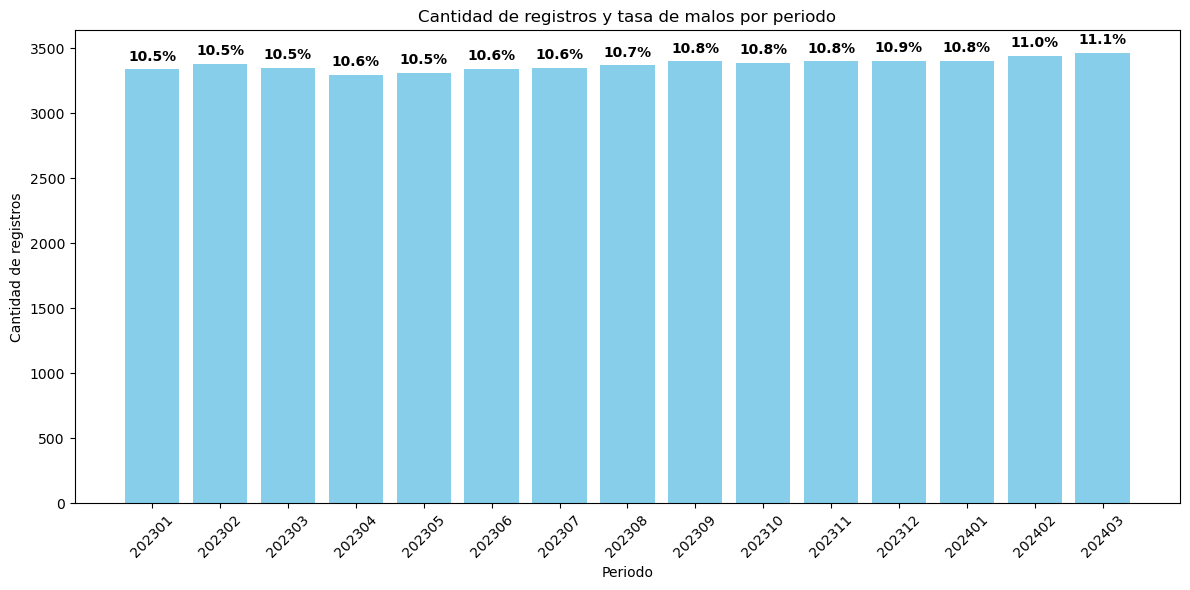

In [9]:
# Target (FLG_CLI_DEF60) = mas de 60 dias de mora en los siguientes 12 meses
df_plot = (
    df.groupby("PERIODO")
      .agg(
          n_registros=("PERIODO", "count"),
          tasa_malos=("FLG_CLI_DEF60", "mean")  # proporción de 1
      )
      .sort_index()
)
df_plot["tasa_malos_pct"] = df_plot["tasa_malos"] * 100
plt.figure(figsize=(12,6))
bars = plt.bar(df_plot.index.astype(str), df_plot["n_registros"], color="skyblue")
for i, (idx, row) in enumerate(df_plot.iterrows()):
    plt.text(
        i, 
        row["n_registros"] + (row["n_registros"] * 0.02), 
        f"{row['tasa_malos_pct']:.1f}%",
        ha="center",
        fontsize=10,
        fontweight="bold"
    )
plt.title("Cantidad de registros y tasa de malos por periodo")
plt.xlabel("Periodo")
plt.ylabel("Cantidad de registros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
cols_no_features = ['FLG_CLI_DEF60', 'PERIODO', 'ID'] # columnas que no serviran para predecir target
cols_features = [a for a in df.columns if a not in cols_no_features]

## 3.2) Analisis de Nulos en variables

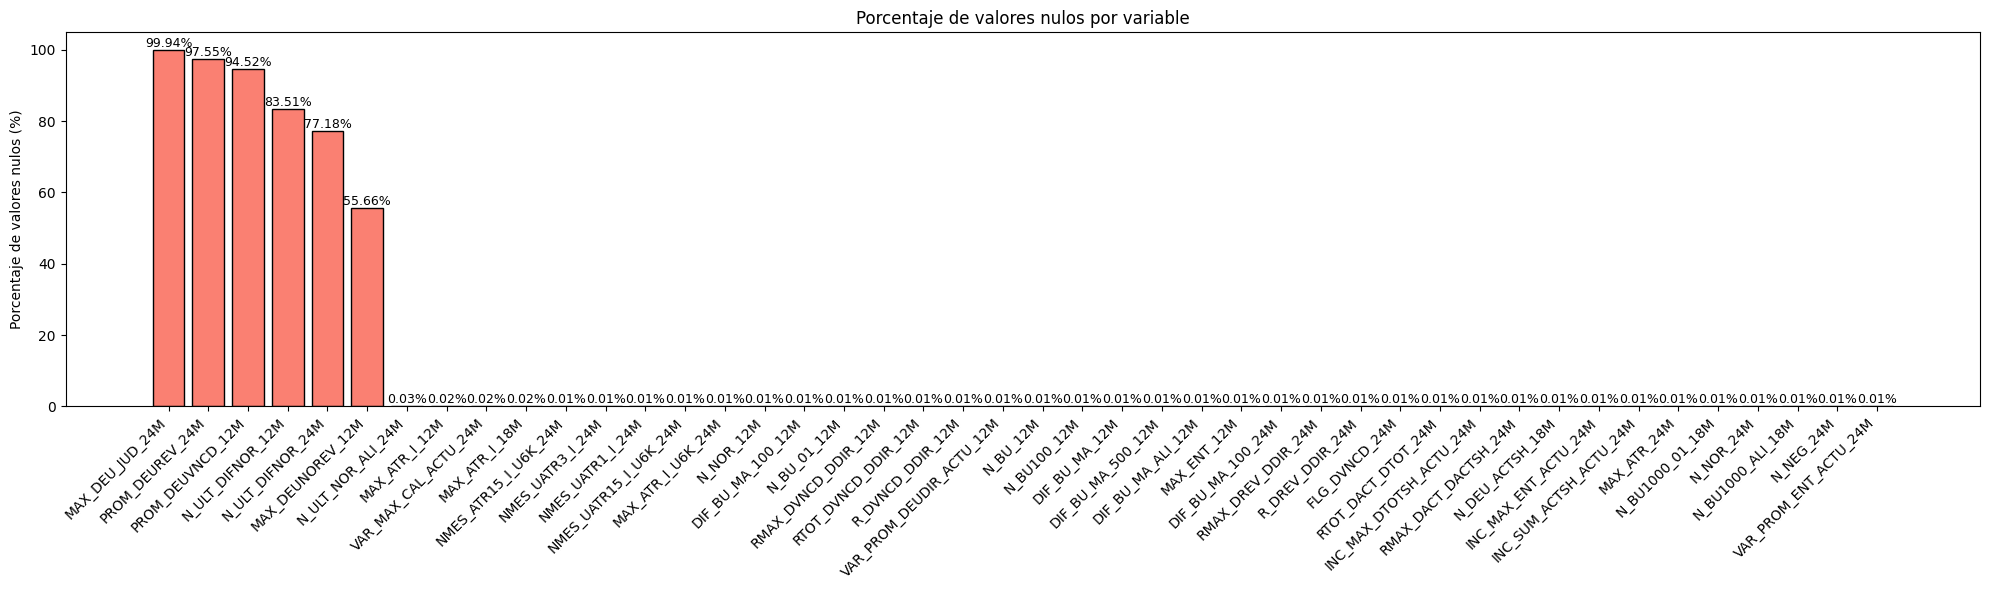

In [8]:
missing_percent = df[cols_features].isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

plt.figure(figsize=(20,6))
bars = plt.bar(missing_percent.index, missing_percent, color="salmon", edgecolor="black")

plt.ylabel("Porcentaje de valores nulos (%)")
plt.title("Porcentaje de valores nulos por variable")
plt.xticks(rotation=45, ha="right")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}%",
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()

In [9]:
# Establecemos como regla, eliminar aquellas varaiibles que tengan mas de 90% de nulos debido a que su cantidad es demasiado grande
cols_keep = missing_percent[missing_percent <= 90].index
df_filtrado = df[cols_keep]
print("Columnas eliminadas:", set(cols_features) - set(cols_keep))
vars_missing_m_90 = set(cols_features) - set(cols_keep)
print("Columnas restantes:", df_filtrado.shape[1])

Columnas eliminadas: {'PROM_DEUREV_24M', 'MAX_DEU_JUD_24M', 'PROM_DEUVNCD_12M'}
Columnas restantes: 41


## 3.3) Eliminacion de Variables por GINI

In [10]:
target_col = "FLG_CLI_DEF60"

def calcular_gini(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return np.abs(2 * auc - 1)
resultados = []
for col in cols_keep:
    if col == target_col:
        continue
    temp = df[[col, target_col]].dropna()
    if temp[col].nunique() > 1:
        try:
            gini = calcular_gini(temp[target_col], temp[col])
            resultados.append({"variable": col, "gini": gini})
        except:
            pass
df_gini = pd.DataFrame(resultados).sort_values("gini", ascending=False).reset_index(drop=True)
df_gini

,variable,gini
0,MAX_ATR_I_U6K_24M,0.599461
1,MAX_ATR_I_12M,0.584765
2,MAX_ATR_I_18M,0.572790
3,N_ULT_DIFNOR_24M,0.407155
4,NMES_ATR15_I_U6K_24M,0.406818
5,N_ULT_DIFNOR_12M,0.341311
6,MAX_ATR_24M,0.312786
7,NMES_UATR1_I_24M,0.285455
8,DIF_BU_MA_100_12M,0.278561
9,DIF_BU_MA_12M,0.277934


In [11]:
# Vamos a eliminar aquellas variables que tienen un gini bajo, es decir menor a 5%
vars_gini_bajo = df_gini[df_gini['gini']<0.05]
vars_gini_bajo

,variable,gini
33,NMES_UATR15_I_U6K_24M,0.043617
34,N_NEG_24M,0.042934
35,INC_MAX_DTOTSH_ACTU_24M,0.036731
36,N_DEU_ACTSH_18M,0.035886
37,INC_MAX_ENT_ACTU_24M,0.031567
38,RMAX_DREV_DDIR_24M,0.019963
39,R_DREV_DDIR_24M,0.019903
40,MAX_DEUNOREV_12M,0.017121


In [12]:
vars_quitar = set(vars_gini_bajo['variable'].to_list() + list(vars_missing_m_90)) # tomando en cuenta gini bajo + missings
vars_quitar

{'INC_MAX_DTOTSH_ACTU_24M',
 'INC_MAX_ENT_ACTU_24M',
 'MAX_DEUNOREV_12M',
 'MAX_DEU_JUD_24M',
 'NMES_UATR15_I_U6K_24M',
 'N_DEU_ACTSH_18M',
 'N_NEG_24M',
 'PROM_DEUREV_24M',
 'PROM_DEUVNCD_12M',
 'RMAX_DREV_DDIR_24M',
 'R_DREV_DDIR_24M'}

In [13]:
cols_features_v2 = [a for a in cols_features if a not in vars_quitar]
print(len(cols_features_v2))
cols_features_v2

33


['DIF_BU_MA_100_12M',
 'DIF_BU_MA_100_24M',
 'DIF_BU_MA_12M',
 'DIF_BU_MA_500_12M',
 'DIF_BU_MA_ALI_12M',
 'FLG_DVNCD_24M',
 'INC_SUM_ACTSH_ACTU_24M',
 'MAX_ATR_24M',
 'MAX_ATR_I_12M',
 'MAX_ATR_I_18M',
 'MAX_ATR_I_U6K_24M',
 'MAX_ENT_12M',
 'NMES_ATR15_I_U6K_24M',
 'NMES_UATR1_I_24M',
 'NMES_UATR3_I_24M',
 'N_BU1000_01_18M',
 'N_BU1000_ALI_18M',
 'N_BU100_12M',
 'N_BU_01_12M',
 'N_BU_12M',
 'N_NOR_12M',
 'N_NOR_24M',
 'N_ULT_DIFNOR_12M',
 'N_ULT_DIFNOR_24M',
 'N_ULT_NOR_ALI_24M',
 'RMAX_DACT_DACTSH_24M',
 'RMAX_DVNCD_DDIR_12M',
 'RTOT_DACT_DTOT_24M',
 'RTOT_DVNCD_DDIR_12M',
 'R_DVNCD_DDIR_12M',
 'VAR_MAX_CAL_ACTU_24M',
 'VAR_PROM_DEUDIR_ACTU_12M',
 'VAR_PROM_ENT_ACTU_24M']

## 3.4) Eliminacion de Variables por correlacion

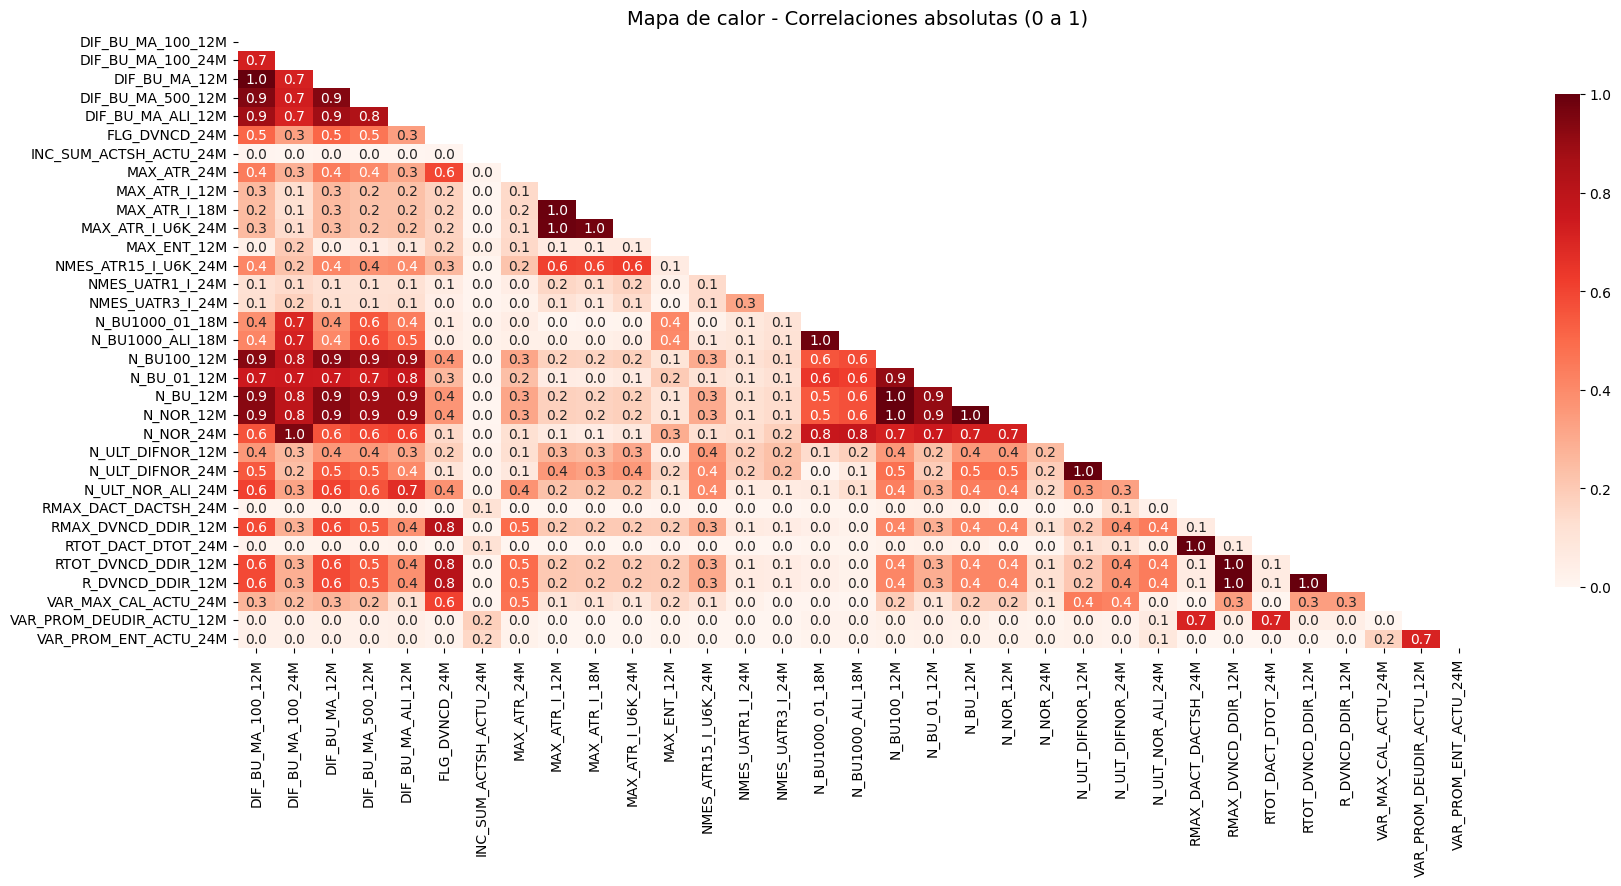

In [14]:
df_corr = df[cols_features_v2].corr().abs()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
plt.figure(figsize=(20,8))
sns.heatmap(
    df_corr, 
    mask=mask,          
    cmap="Reds",        # solo tonos de 0 a 1
    annot=True,         
    fmt=".1f",          
    vmin=0, vmax=1,     # rango de correlación
    cbar_kws={"shrink": 0.8}
)
plt.title("Mapa de calor - Correlaciones absolutas (0 a 1)", fontsize=14)
plt.show()

In [15]:
# Eliminamos aquellas variables que tienen una correlacion mayor a threshold
def remove_highly_correlated(dataframe, threshold=0.5):
    corr_matrix = dataframe.corr().abs()
    np.fill_diagonal(corr_matrix.values, 0)
    keep = list(corr_matrix.columns)
    while True:
        # Buscar la correlación más alta
        max_corr = corr_matrix.max().max()
        if max_corr < threshold:
            break
        col1, col2 = np.where(corr_matrix == max_corr)
        col1, col2 = corr_matrix.columns[col1[0]], corr_matrix.columns[col2[0]]
        if col2 in keep:
            keep.remove(col2)
        corr_matrix = dataframe[keep].corr().abs()
        np.fill_diagonal(corr_matrix.values, 0)

    return dataframe[keep]
df_filtrado = remove_highly_correlated(df[cols_features_v2], threshold=0.6)
vars_finales = df_filtrado.columns
print("Columnas finales:", df_filtrado.shape[1])
print("Columnas seleccionadas:", df_filtrado.columns.tolist())

Columnas finales: 12
Columnas seleccionadas: ['DIF_BU_MA_100_12M', 'FLG_DVNCD_24M', 'INC_SUM_ACTSH_ACTU_24M', 'MAX_ATR_24M', 'MAX_ATR_I_12M', 'MAX_ENT_12M', 'NMES_UATR1_I_24M', 'NMES_UATR3_I_24M', 'N_BU1000_01_18M', 'N_ULT_DIFNOR_12M', 'RMAX_DACT_DACTSH_24M', 'VAR_PROM_ENT_ACTU_24M']


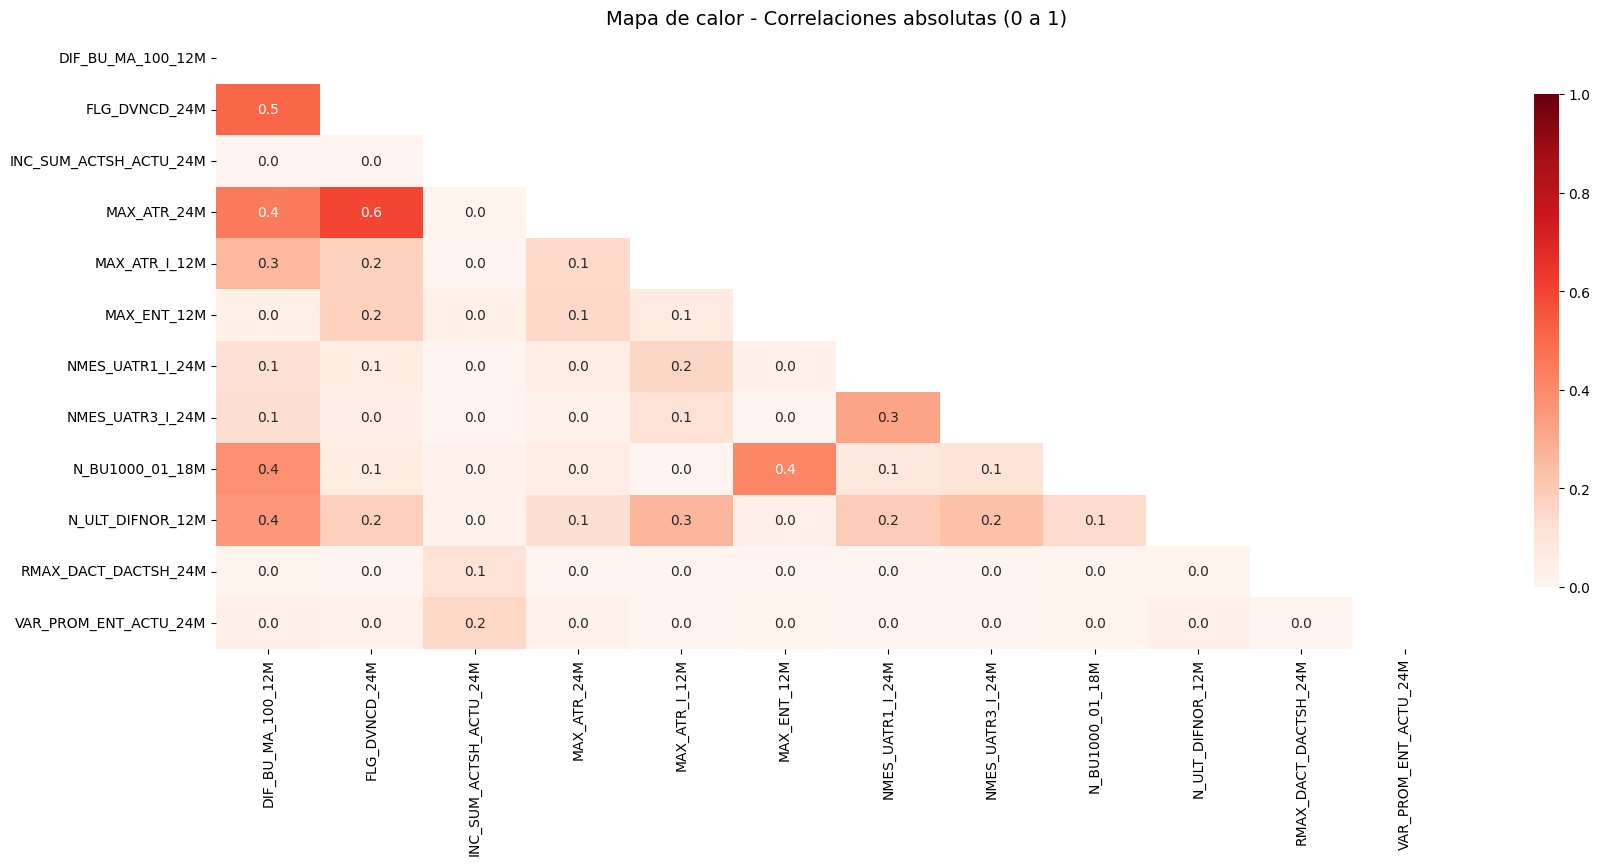

In [16]:
# Calcular matriz de correlación con variables ya filtradas
df_corr = df_filtrado.corr().abs()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
plt.figure(figsize=(20,8))
sns.heatmap(
    df_corr,
    mask=mask,
    cmap="Reds",
    annot=True,
    fmt=".1f",
    vmin=0, vmax=1, 
    cbar_kws={"shrink": 0.8}
)
plt.title("Mapa de calor - Correlaciones absolutas (0 a 1)", fontsize=14)
plt.show()

In [17]:
vars_finales

Index(['DIF_BU_MA_100_12M', 'FLG_DVNCD_24M', 'INC_SUM_ACTSH_ACTU_24M',
       'MAX_ATR_24M', 'MAX_ATR_I_12M', 'MAX_ENT_12M', 'NMES_UATR1_I_24M',
       'NMES_UATR3_I_24M', 'N_BU1000_01_18M', 'N_ULT_DIFNOR_12M',
       'RMAX_DACT_DACTSH_24M', 'VAR_PROM_ENT_ACTU_24M'],
      dtype='object')

## 3.5) Analisis Bivariado de variables en funcion de la Target

In [18]:
dicc_vars_finales = {
    'DIF_BU_MA_100_12M': 'Diferencia entre meses de buen y mal comportamiento ultimos 12 meses',
    'FLG_DVNCD_24M': 'Flag Deuda Vencida ultimos 24 meses',
    'INC_SUM_ACTSH_ACTU_24M': 'Incremento de Deuda Total u24 meses',
    'MAX_ATR_24M': 'Numero Maximo de dias de atraso u24 meses',
    'MAX_ATR_I_12M': 'Maximo Atraso en los ultimos 12 meses',
    'MAX_ENT_12M': 'Maxima Cantidad de Entidades Acreedoras u12 meses',
    'NMES_UATR1_I_24M': 'Numero de Meses desde el ultimo atraso >= 1 en los ultimos 24 meses',
    'NMES_UATR3_I_24M': 'Numero de Meses desde el ultimo atraso >= 3 en los ultimos 24 meses',
    'N_BU1000_01_18M': 'Meses de Buen Comportamiento en ultimos 18 meses',
    'N_ULT_DIFNOR_12M': 'Numero de meses desde la ultima ve que se reporto clasificacion diferente de normal ultimos 12 meses', 
    'RMAX_DACT_DACTSH_24M': 'Ratio Maxima deuda activa / Maxima Deuda Activa s/h u24m', # tiene sentido vas pagando tu deuda , laso tas deudas se van achicando, valor mayor deudas s/h se van achhicando
    'VAR_PROM_ENT_ACTU_24M': 'Variacion de Entidades acreedoras u18 meses'
}

In [19]:
list_opt = list()
y = df['FLG_CLI_DEF60'].to_numpy() #target
for var in vars_finales:
    print(f'Variable: {var}')
    x_parcial = df[var].to_numpy() #variable procesar
    optb_temp = OptimalBinning(
        name=var,
        dtype="numerical",
        solver="cp",
        monotonic_trend = 'auto_asc_desc'
    )
    optb_temp.fit(x_parcial, y)
    list_opt.append(optb_temp)
    del(x_parcial)
    del(optb_temp)

Variable: DIF_BU_MA_100_12M
Variable: FLG_DVNCD_24M
Variable: INC_SUM_ACTSH_ACTU_24M
Variable: MAX_ATR_24M
Variable: MAX_ATR_I_12M
Variable: MAX_ENT_12M
Variable: NMES_UATR1_I_24M
Variable: NMES_UATR3_I_24M
Variable: N_BU1000_01_18M
Variable: N_ULT_DIFNOR_12M
Variable: RMAX_DACT_DACTSH_24M
Variable: VAR_PROM_ENT_ACTU_24M


Variable: DIF_BU_MA_100_12M: Diferencia entre meses de buen y mal comportamiento ultimos 12 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.50)",3581,0.070743,2588,993,0.277297,-1.163505,0.146629,0.017360
1,"[5.50, 8.50)",6002,0.118570,4983,1019,0.169777,-0.534204,0.041582,0.005137
2,"[8.50, 10.50)",6332,0.125089,5430,902,0.142451,-0.326335,0.015127,0.001883
3,"[10.50, inf)",34700,0.685500,32197,2503,0.072133,0.432969,0.108378,0.013442
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,5,0.000099,4,1,0.200000,-0.73512,0.000071,0.000009
Totals,,50620,1.000000,45202,5418,0.107033,,0.311786,0.037830


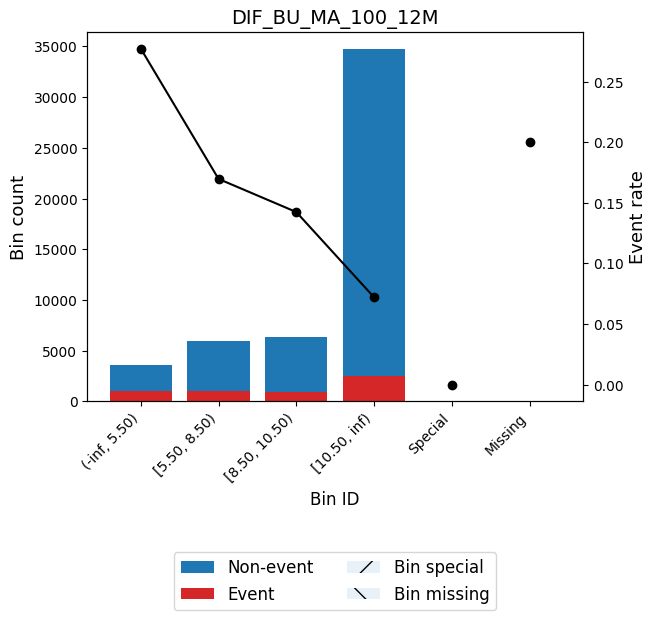

Variable: FLG_DVNCD_24M: Flag Deuda Vencida ultimos 24 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",46558,0.919755,42162,4396,0.094420,0.13941,0.016921,0.002113
1,"[0.50, inf)",4058,0.080166,3036,1022,0.251848,-1.032635,0.125429,0.015017
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,4,0.000079,4,0,0.000000,0.0,0.000000,0.000000
Totals,,50620,1.000000,45202,5418,0.107033,,0.142350,0.017131


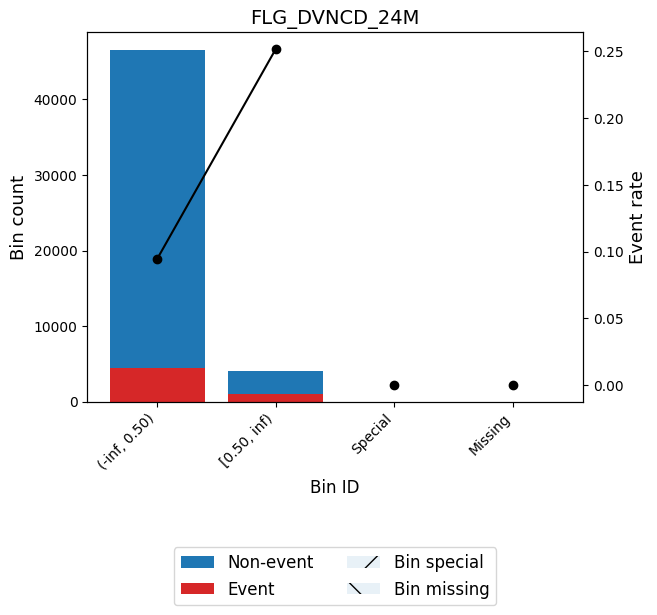

Variable: INC_SUM_ACTSH_ACTU_24M: Incremento de Deuda Total u24 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.04)",4608,0.091031,3923,685,0.148655,-0.376221,0.014914,0.001853
1,"[6.04, 8.80)",5140,0.101541,4437,703,0.136770,-0.279038,0.008816,0.001098
2,"[8.80, 11.63)",5941,0.117365,5207,734,0.123548,-0.162164,0.003289,0.000411
3,"[11.63, 13.84)",4516,0.089214,3974,542,0.120018,-0.129152,0.001565,0.000196
4,"[13.84, 17.28)",6713,0.132616,6013,700,0.104275,0.029184,0.000112,0.000014
5,"[17.28, 20.52)",5350,0.105689,4796,554,0.103551,0.036958,0.000142,0.000018
6,"[20.52, 25.57)",6118,0.120861,5509,609,0.099542,0.080906,0.000766,0.000096
7,"[25.57, 48.72)",8843,0.174694,8146,697,0.078819,0.337082,0.017383,0.002163
8,"[48.72, inf)",3387,0.066910,3193,194,0.057278,0.679443,0.023666,0.002903
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


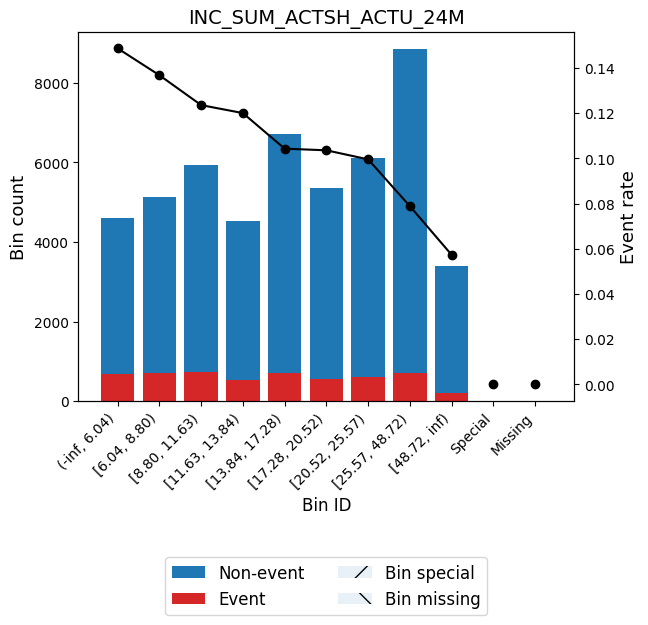

Variable: MAX_ATR_24M: Numero Maximo de dias de atraso u24 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",34596,0.683445,32254,2342,0.067696,0.501222,0.140989,0.017441
1,"[2.50, 6.50)",3201,0.063236,2816,385,0.120275,-0.131585,0.001153,0.000144
2,"[6.50, 16.50)",5202,0.102766,4319,883,0.169742,-0.533961,0.036003,0.004448
3,"[16.50, 28.50)",2909,0.057467,2290,619,0.212788,-0.813213,0.051710,0.006291
4,"[28.50, inf)",4708,0.093007,3519,1189,0.252549,-1.03635,0.146750,0.017565
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,4,0.000079,4,0,0.000000,0.0,0.000000,0.000000
Totals,,50620,1.000000,45202,5418,0.107033,,0.376605,0.045889


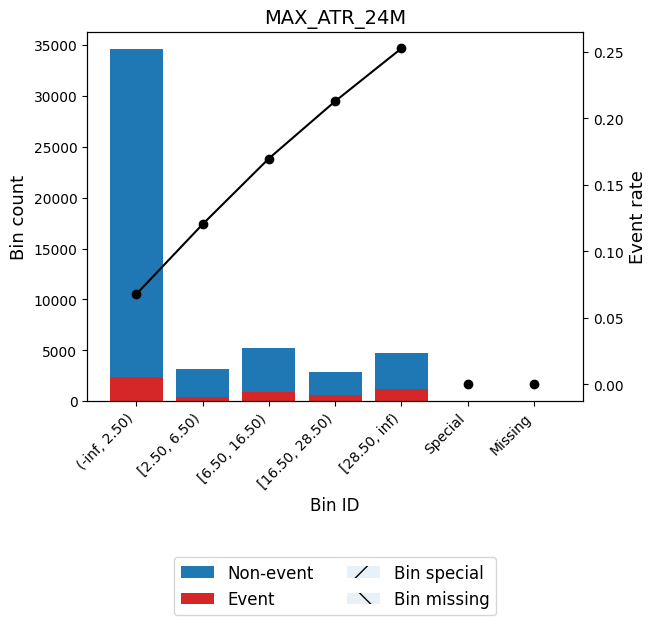

Variable: MAX_ATR_I_12M: Maximo Atraso en los ultimos 12 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",8820,0.174239,8614,206,0.023356,1.611853,0.245881,0.027788
1,"[0.50, 1.50)",7913,0.156322,7618,295,0.037280,1.129879,0.128901,0.015307
2,"[1.50, 2.50)",4322,0.085381,4110,212,0.049051,0.843177,0.043674,0.005303
3,"[2.50, 3.50)",5099,0.100731,4843,256,0.050206,0.818698,0.049033,0.005963
4,"[3.50, 4.50)",4137,0.081727,3883,254,0.061397,0.605614,0.023633,0.002910
5,"[4.50, 5.50)",3066,0.060569,2819,247,0.080561,0.313335,0.005256,0.000654
6,"[5.50, 7.50)",4621,0.091288,4226,395,0.085479,0.248711,0.005120,0.000638
7,"[7.50, 9.50)",2700,0.053339,2353,347,0.128519,-0.207293,0.002486,0.000310
8,"[9.50, 13.50)",2887,0.057033,2411,476,0.164877,-0.499036,0.017225,0.002131
9,"[13.50, 21.50)",2967,0.058613,2320,647,0.218065,-0.844438,0.057499,0.006981


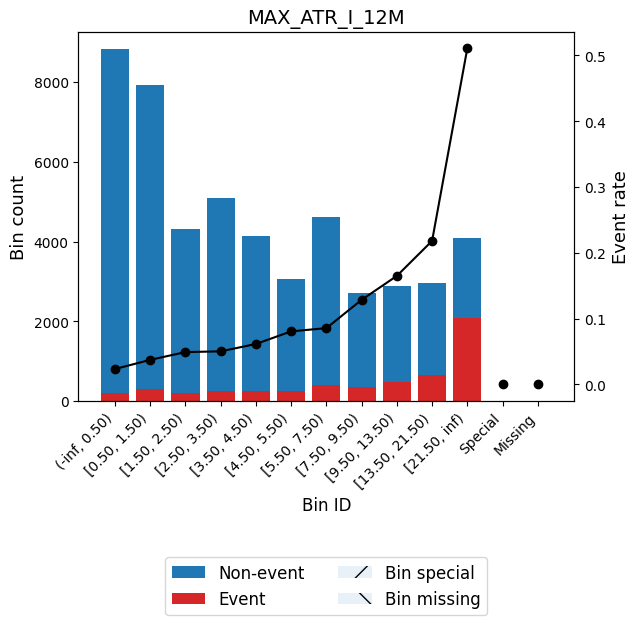

Variable: MAX_ENT_12M: Maxima Cantidad de Entidades Acreedoras u12 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",19802,0.391189,18314,1488,0.075144,0.388818,0.050748,0.006304
1,"[1.50, 2.50)",15835,0.312821,14130,1705,0.107673,-0.00668,0.000014,0.000002
2,"[2.50, 3.50)",9553,0.188720,8267,1286,0.134617,-0.26068,0.014198,0.001770
3,"[3.50, inf)",5425,0.107171,4487,938,0.172903,-0.556225,0.041083,0.005070
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,5,0.000099,4,1,0.200000,-0.73512,0.000071,0.000009
Totals,,50620,1.000000,45202,5418,0.107033,,0.106115,0.013154


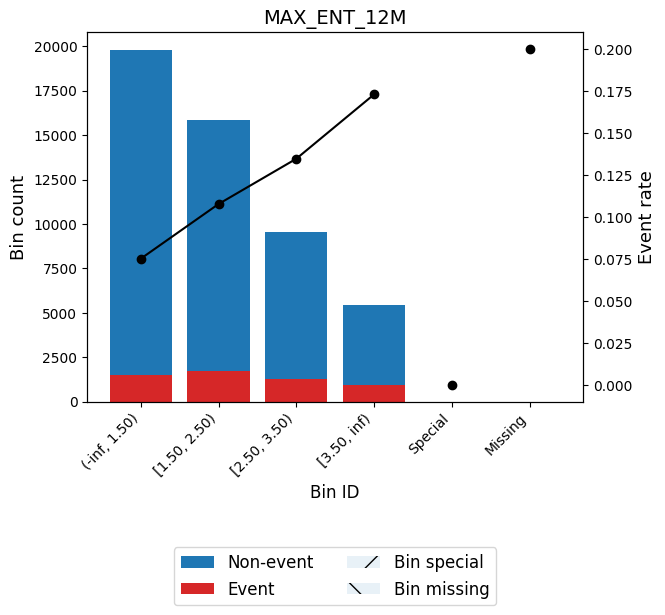

Variable: NMES_UATR1_I_24M: Numero de Meses desde el ultimo atraso >= 1 en los ultimos 24 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",28917,0.571256,24515,4402,0.152229,-0.404188,0.109185,0.013556
1,"[0.50, 1.50)",6391,0.126254,5985,406,0.063527,0.569244,0.032715,0.004035
2,"[1.50, 2.50)",3722,0.073528,3522,200,0.053735,0.747052,0.030631,0.003742
3,"[2.50, 5.50)",5554,0.109719,5312,242,0.043572,0.967371,0.070474,0.008481
4,"[5.50, 9.50)",2995,0.059166,2889,106,0.035392,1.183812,0.052501,0.006204
5,"[9.50, inf)",3034,0.059937,2972,62,0.020435,1.748441,0.094951,0.010556
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,7,0.000138,7,0,0.000000,0.0,0.000000,0.000000
Totals,,50620,1.000000,45202,5418,0.107033,,0.390456,0.046575


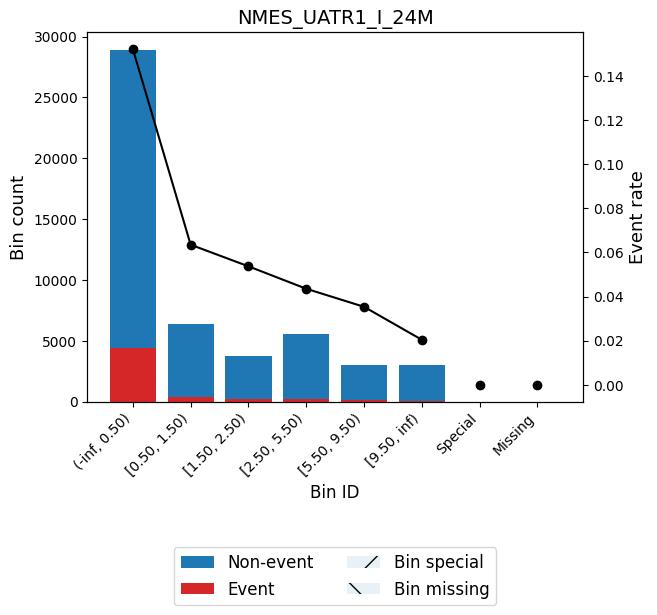

Variable: NMES_UATR3_I_24M: Numero de Meses desde el ultimo atraso >= 3 en los ultimos 24 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",30723,0.606934,26487,4236,0.137877,-0.28838,0.056485,0.007036
1,"[0.50, 1.50)",4006,0.079139,3635,371,0.092611,0.160748,0.001920,0.000240
2,"[1.50, 2.50)",2766,0.054642,2561,205,0.074114,0.403729,0.007598,0.000943
3,"[2.50, 4.50)",3716,0.073410,3503,213,0.057320,0.678668,0.025914,0.003178
4,"[4.50, 7.50)",3206,0.063335,3039,167,0.052090,0.779875,0.028394,0.003462
5,"[7.50, 13.50)",3419,0.067542,3283,136,0.039778,1.062443,0.050496,0.006031
6,"[13.50, inf)",2777,0.054860,2687,90,0.032409,1.274956,0.054610,0.006399
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,7,0.000138,7,0,0.000000,0.0,0.000000,0.000000
Totals,,50620,1.000000,45202,5418,0.107033,,0.225416,0.027289


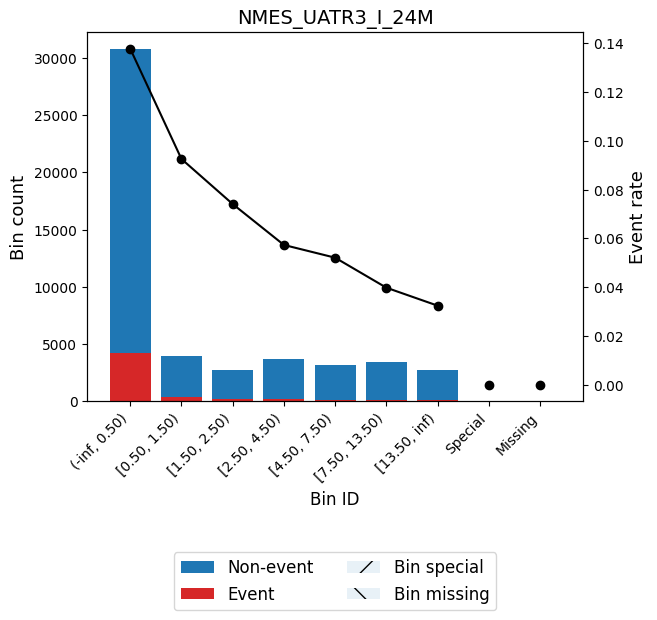

Variable: N_BU1000_01_18M: Meses de Buen Comportamiento en ultimos 18 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",8626,0.170407,7526,1100,0.127521,-0.198361,0.007246,9.042815e-04
1,"[7.50, 13.50)",9802,0.193639,8660,1142,0.116507,-0.095481,0.001833,2.290010e-04
2,"[13.50, 15.50)",4454,0.087989,3944,510,0.114504,-0.075875,0.000522,6.521659e-05
3,"[15.50, 17.50)",6229,0.123054,5559,670,0.107561,-0.005519,0.000004,4.694991e-07
4,"[17.50, inf)",21505,0.424832,19509,1996,0.092816,0.158316,0.010005,1.249281e-03
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
6,Missing,4,0.000079,4,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,50620,1.000000,45202,5418,0.107033,,0.019609,2.448249e-03


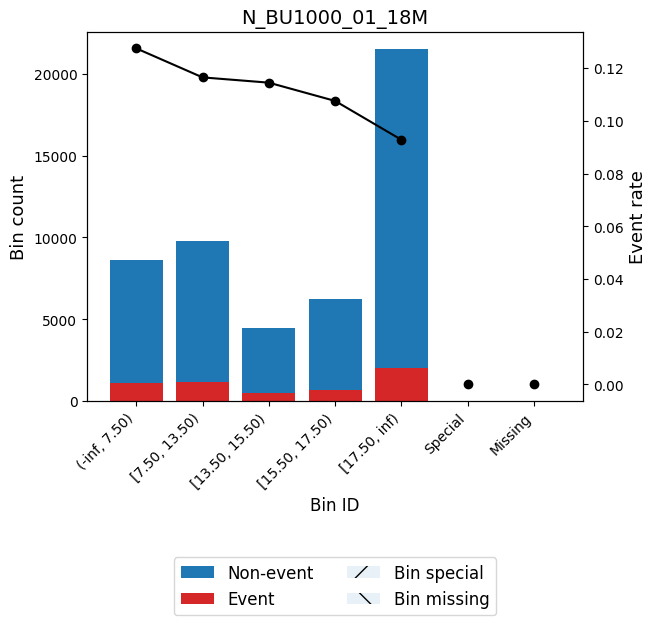

Variable: N_ULT_DIFNOR_12M: Numero de meses desde la ultima ve que se reporto clasificacion diferente de normal ultimos 12 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",4611,0.091090,2909,1702,0.369117,-1.585409,0.396007,0.044892
1,"[1.50, inf)",3736,0.073805,3223,513,0.137313,-0.283623,0.006632,0.000826
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,42273,0.835105,39070,3203,0.075769,0.379852,0.103762,0.012893
Totals,,50620,1.000000,45202,5418,0.107033,,0.506402,0.058611


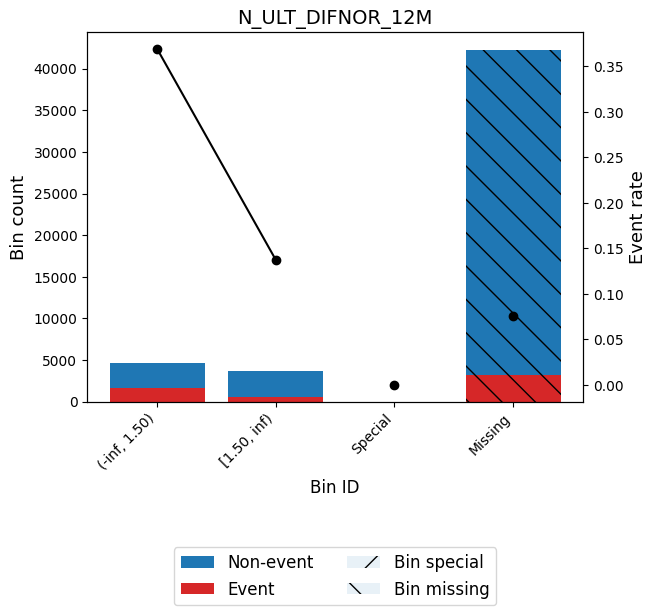

Variable: RMAX_DACT_DACTSH_24M: Ratio Maxima deuda activa / Maxima Deuda Activa s/h u24m


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.95)",3611,0.071335,3462,149,0.041263,1.024241,0.050279,0.006024
1,"[0.95, 1.13)",4446,0.087831,4093,353,0.079397,0.329151,0.008359,0.001040
2,"[1.13, 1.22)",3898,0.077005,3545,353,0.090559,0.185411,0.002461,0.000307
3,"[1.22, 1.37)",6486,0.128131,5805,681,0.104995,0.021498,0.000059,0.000007
4,"[1.37, 1.53)",6898,0.136270,6119,779,0.112931,-0.060272,0.000507,0.000063
5,"[1.53, 1.70)",6652,0.131411,5895,757,0.113800,-0.068918,0.000641,0.000080
6,"[1.70, 1.81)",3476,0.068669,3070,406,0.116801,-0.098335,0.000690,0.000086
7,"[1.81, 2.03)",5481,0.108277,4802,679,0.123883,-0.165248,0.003154,0.000394
8,"[2.03, 2.22)",2985,0.058969,2606,379,0.126968,-0.193379,0.002379,0.000297
9,"[2.22, inf)",6683,0.132023,5801,882,0.131977,-0.237821,0.008194,0.001022


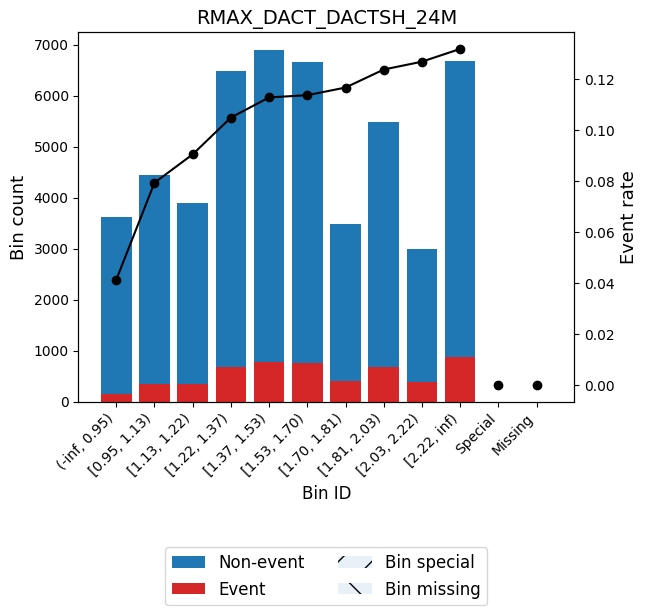

Variable: VAR_PROM_ENT_ACTU_24M: Variacion de Entidades acreedoras u18 meses


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -0.43)",2713,0.053595,2226,487,0.179506,-0.601717,0.024454,0.003011
1,"[-0.43, -0.30)",5602,0.110668,4774,828,0.147804,-0.369488,0.017443,0.002168
2,"[-0.30, -0.15)",7119,0.140636,6104,1015,0.142576,-0.327359,0.017121,0.002131
3,"[-0.15, -0.09)",2571,0.050790,2217,354,0.137690,-0.286801,0.004672,0.000582
4,"[-0.09, -0.00)",3300,0.065192,2940,360,0.109091,-0.021354,0.000030,0.000004
5,"[-0.00, inf)",29311,0.579040,26937,2374,0.080993,0.30751,0.048512,0.006040
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,4,0.000079,4,0,0.000000,0.0,0.000000,0.000000
Totals,,50620,1.000000,45202,5418,0.107033,,0.112232,0.013936


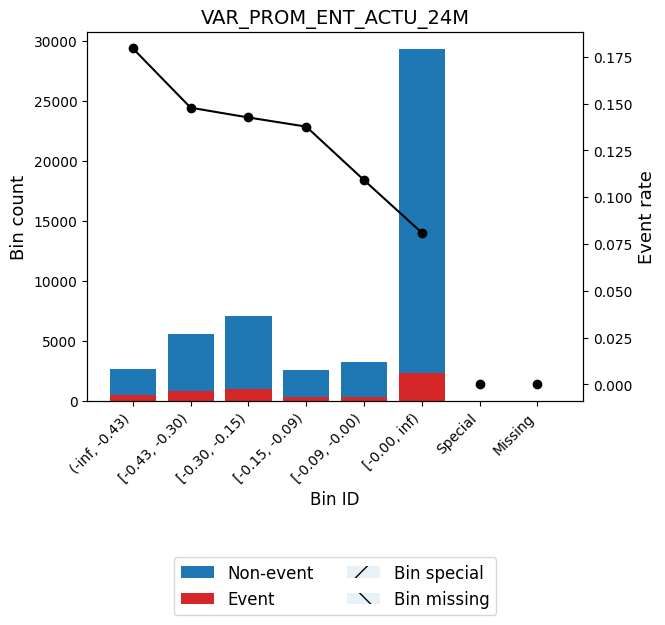

In [20]:
dict_variables_cortes_cont = dict()
for a in list_opt:
    binning_table = a.binning_table
    print(f'''Variable: {a.name}: {dicc_vars_finales.get(a.name)}''')
    build_table = binning_table.build()
    display(build_table)
    binning_table.plot(metric="event_rate", show_bin_labels=True)

## 3.6) Imputacion de Missings

In [21]:
# Debido a que tenemos pocos nulos y estos siguen un ordenamiento segun la tasa de malos vamos a realiar imputaciones por criterio experto
df['DIF_BU_MA_100_12M'] = df['DIF_BU_MA_100_12M'].fillna(0) # Sin registros no hay diferencia, imputamos por 0 , comportamiento similar de tm
df['FLG_DVNCD_24M'] = df['FLG_DVNCD_24M'].fillna(0) # No aparece en registros por ende no tiene deuda vencida, posible cliente nuevo
df['INC_SUM_ACTSH_ACTU_24M'] = df['INC_SUM_ACTSH_ACTU_24M'].fillna(0) # No aparece en registros incremento = 0
df['MAX_ATR_24M'] = df['MAX_ATR_24M'].fillna(0) # No aparece en registros dm = 0 , similar tm
df['MAX_ATR_I_12M'] = df['MAX_ATR_I_12M'].fillna(0) # No aparece en registros dm = 0 , similar tm
df['MAX_ENT_12M'] = df['MAX_ENT_12M'].fillna(0) # No aparece en registros, error de bd imputamos por 0
df['NMES_UATR1_I_24M'] = df['NMES_UATR1_I_24M'].fillna(99) # No aparece en registros, cleinte nuevo imputamos por valor alto tipo 99
df['NMES_UATR3_I_24M'] = df['NMES_UATR3_I_24M'].fillna(99) # No aparece en registros, cleinte nuevo imputamos por valor alto tipo 99
df['N_BU1000_01_18M'] = df['N_BU1000_01_18M'].fillna(99) # No aparece en registros, cleinte nuevo imputamos por valor alto tipo 99
df['N_ULT_DIFNOR_12M'] = df['N_ULT_DIFNOR_12M'].fillna(99) #Cliente nuevo ponemos meses altos 
df['RMAX_DACT_DACTSH_24M'] = df['RMAX_DACT_DACTSH_24M'].fillna(0) #Imputamos por 0
df['VAR_PROM_ENT_ACTU_24M'] = df['VAR_PROM_ENT_ACTU_24M'].fillna(0) #Imputamos por 0

## 3.7) Deteccion de Outliers

In [22]:
X = df[vars_finales]

iso = IsolationForest(
    n_estimators=200,
    contamination=0.01,
    random_state=42,
    n_jobs=-1 
)

iso.fit(X)

df["is_outlier"] = iso.predict(X)
df["score"] = iso.decision_function(X)

In [23]:
df.groupby(['is_outlier'])['is_outlier'].count()

is_outlier
-1      507
 1    50113
Name: is_outlier, dtype: int64

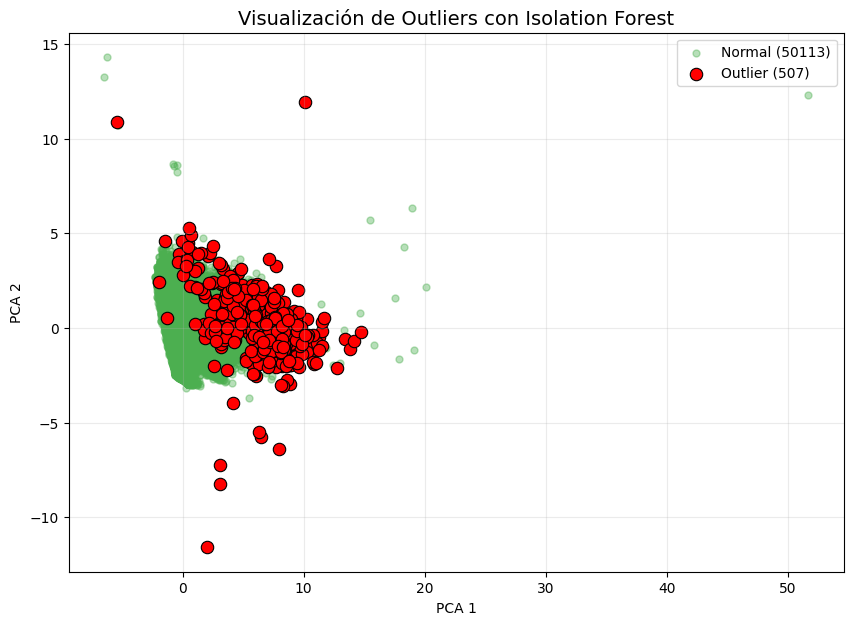

In [27]:
# Visualiacion de outliers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state = 42)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

conteo = df["is_outlier"].value_counts()
n_normales = conteo.get(1, 0)
n_outliers = conteo.get(-1, 0)

normal = df[df["is_outlier"] == 1]
out    = df[df["is_outlier"] == -1]

plt.figure(figsize=(10,7))
plt.scatter(
    normal["pca1"], normal["pca2"],
    s=25, color="#4CAF50", alpha=0.4, label=f"Normal ({n_normales})"
)
plt.scatter(
    out["pca1"], out["pca2"],
    s=80, color="red", edgecolor="black", linewidth=0.8,
    label=f"Outlier ({n_outliers})"
)

plt.title("Visualización de Outliers con Isolation Forest", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(alpha=0.25)
plt.show()

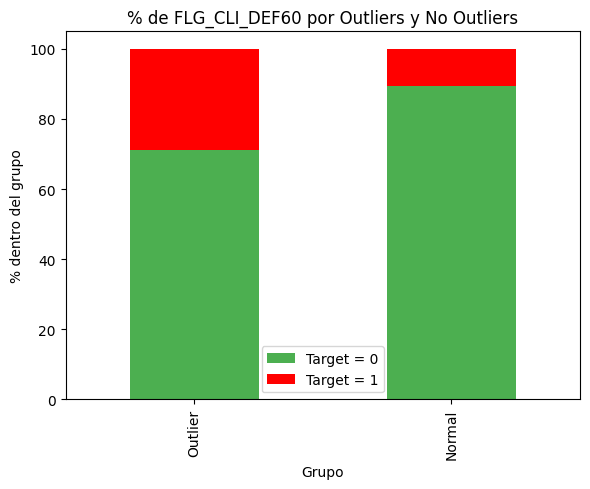

In [28]:
tabla = pd.crosstab(
    df["is_outlier"],
    df["FLG_CLI_DEF60"],
    normalize="index"   # cada fila suma 1
) * 100

tabla.index = tabla.index.map({1: "Normal", -1: "Outlier"})
tabla.columns = ["Target = 0", "Target = 1"]
ax = tabla.plot(
    kind="bar",
    stacked=True,
    figsize=(6,5),
    color=["#4CAF50", "red"]
)

plt.ylabel("% dentro del grupo")
plt.xlabel("Grupo")
plt.title("% de FLG_CLI_DEF60 por Outliers y No Outliers")
plt.legend(title="")
plt.tight_layout()
plt.show()

# 4) Entrenamiento de Modelos

In [88]:
TARGET_COL = "FLG_CLI_DEF60"

df_train = df[(df['PERIODO'] < 201801)&(df['is_outlier']==1)].copy()
df_oot   = df[(df['PERIODO'] >= 201801)&(df['is_outlier']==1)].copy()

X_train = df_train[vars_finales].copy()
y_train = df_train[TARGET_COL].astype(int)

X_oot = df_oot[vars_finales]
y_oot = df_oot[TARGET_COL].astype(int)

In [89]:
SEED = 42
N_SPLITS = 5
MODELS_DIR = "models"

In [118]:
os.makedirs(MODELS_DIR, exist_ok=True)

def gini_score(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    return np.abs(2 * auc - 1)

def ks_statistic(y_true, y_score):
    data = pd.DataFrame({"y": y_true, "score": y_score})
    data = data.sort_values("score", ascending=False)
    data["cum_bad"] = (data["y"] == 1).cumsum() / (data["y"] == 1).sum()
    data["cum_good"] = (data["y"] == 0).cumsum() / (data["y"] == 0).sum()
    return np.max(np.abs(data["cum_bad"] - data["cum_good"]))

In [91]:
# Normalización (mismo scaler para train y OOT) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_oot_scaled   = scaler.transform(X_oot)

X_train_scaled = pd.DataFrame(
    X_train_scaled, index=X_train.index, columns=X_train.columns
)
X_oot_scaled = pd.DataFrame(
    X_oot_scaled, index=X_oot.index, columns=X_oot.columns
)
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.joblib"))

['models/scaler.joblib']

In [92]:
# Desbalance: pesos de clase
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
ratio = n_neg / n_pos if n_pos > 0 else 1.0
print(f"Desbalance train -> pos: {n_pos}, neg: {n_neg}, ratio neg/pos={ratio:.2f}")

Desbalance train -> pos: 4170, neg: 35759, ratio neg/pos=8.58


In [93]:
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except ImportError:
    HAS_CAT = False

In [94]:
modelos = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "SGDClassifier_log": SGDClassifier(
        loss="log_loss",
        random_state=SEED,
        class_weight="balanced"
    ),
    "DecisionTree": DecisionTreeClassifier(
        random_state=SEED,
        class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=SEED
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        random_state=SEED
    ),
    "AdaBoost": AdaBoostClassifier(
        random_state=SEED
    ),
    "Bagging_DT": BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        random_state=SEED,
        n_jobs=-1
    ),
    "KNN": KNeighborsClassifier(),  # no soporta class_weight
    "SVC": SVC(
        probability=True,
        random_state=SEED,
        class_weight="balanced"   # <-- desbalance
    ),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB()
}
if HAS_XGB:
    modelos["XGBoost"] = XGBClassifier(
        random_state=SEED,
        n_jobs=-1,
        scale_pos_weight=ratio   # <-- desbalance
    )

if HAS_LGBM:
    modelos["LightGBM"] = LGBMClassifier(
        random_state=SEED,
        scale_pos_weight=ratio
    )

if HAS_CAT:
    modelos["CatBoost"] = CatBoostClassifier(
        verbose=False,
        random_state=SEED,
        class_weights=[1.0, ratio]
    )

In [95]:
kf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=SEED
)

In [96]:
resultados = []
for nombre, modelo in modelos.items():
    print(f"\n==============================")
    print(f"Entrenando modelo: {nombre}")
    print(f"==============================")

    auc_folds = []
    gini_folds = []
    ks_folds = []

    #Cross-validation en TRAIN 
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X_train_scaled, y_train), start=1):
        X_tr = X_train_scaled.iloc[idx_tr]
        X_val = X_train_scaled.iloc[idx_val]
        y_tr = y_train.iloc[idx_tr]
        y_val = y_train.iloc[idx_val]

        modelo.fit(X_tr, y_tr)

        if hasattr(modelo, "predict_proba"):
            proba_val = modelo.predict_proba(X_val)[:, 1]
        else:
            proba_val = modelo.decision_function(X_val)
        auc  = roc_auc_score(y_val, proba_val)
        gini = gini_score(y_val, proba_val)
        ks_v = ks_statistic(y_val, proba_val)
        auc_folds.append(auc)
        gini_folds.append(gini)
        ks_folds.append(ks_v)

        print(f"  Fold {fold}: AUC={auc:.4f}, Gini={gini:.4f}, KS={ks_v:.4f}")

    # Métricas promedio en CV
    auc_cv_mean  = float(np.mean(auc_folds))
    gini_cv_mean = float(np.mean(gini_folds))
    ks_cv_mean   = float(np.mean(ks_folds))

    modelo.fit(X_train_scaled, y_train)
    if hasattr(modelo, "predict_proba"):
        proba_oot = modelo.predict_proba(X_oot_scaled)[:, 1]
    else:
        proba_oot = modelo.decision_function(X_oot_scaled)
    auc_oot  = roc_auc_score(y_oot, proba_oot)
    gini_oot = gini_score(y_oot, proba_oot)
    ks_oot   = ks_statistic(y_oot, proba_oot)
    print(f"  >> OOT: AUC={auc_oot:.4f}, Gini={gini_oot:.4f}, KS={ks_oot:.4f}")
    # ---- Guardar modelo entrenado en carpeta models/ ----
    model_path = os.path.join(MODELS_DIR, f"model_{nombre}.joblib")
    joblib.dump(modelo, model_path)

    resultados.append({
        "modelo": nombre,
        "AUC_CV_mean": round(auc_cv_mean, 4),
        "Gini_CV_mean": round(gini_cv_mean, 4),
        "KS_CV_mean": round(ks_cv_mean, 4),
        "AUC_OOT": round(auc_oot, 4),
        "Gini_OOT": round(gini_oot, 4),
        "KS_OOT": round(ks_oot, 4),
        "ruta_modelo": model_path
    })


Entrenando modelo: LogisticRegression
  Fold 1: AUC=0.8117, Gini=0.6234, KS=0.4818
  Fold 2: AUC=0.8072, Gini=0.6144, KS=0.4688
  Fold 3: AUC=0.8110, Gini=0.6221, KS=0.4836
  Fold 4: AUC=0.8274, Gini=0.6548, KS=0.5090
  Fold 5: AUC=0.8111, Gini=0.6222, KS=0.4977
  >> OOT: AUC=0.8174, Gini=0.6349, KS=0.4844

Entrenando modelo: SGDClassifier_log
  Fold 1: AUC=0.7947, Gini=0.5894, KS=0.4490
  Fold 2: AUC=0.7948, Gini=0.5897, KS=0.4464
  Fold 3: AUC=0.7955, Gini=0.5911, KS=0.4521
  Fold 4: AUC=0.7765, Gini=0.5531, KS=0.4533
  Fold 5: AUC=0.7403, Gini=0.4806, KS=0.3813
  >> OOT: AUC=0.8055, Gini=0.6110, KS=0.4588

Entrenando modelo: DecisionTree
  Fold 1: AUC=0.6076, Gini=0.2152, KS=0.2185
  Fold 2: AUC=0.6158, Gini=0.2316, KS=0.2770
  Fold 3: AUC=0.6114, Gini=0.2228, KS=0.2228
  Fold 4: AUC=0.6057, Gini=0.2114, KS=0.2150
  Fold 5: AUC=0.6248, Gini=0.2496, KS=0.2511
  >> OOT: AUC=0.5945, Gini=0.1889, KS=0.4394

Entrenando modelo: RandomForest
  Fold 1: AUC=0.7927, Gini=0.5854, KS=0.4552
  

In [99]:
df_resultados = pd.DataFrame(resultados).sort_values(
    by=["Gini_OOT", "Gini_CV_mean"],
    ascending=False
).reset_index(drop=True)

df_resultados['variacion_gini'] = df_resultados['AUC_OOT'] - df_resultados['Gini_CV_mean']
df_resultados

,modelo,AUC_CV_mean,Gini_CV_mean,KS_CV_mean,AUC_OOT,Gini_OOT,KS_OOT,ruta_modelo,variacion_gini
0,HistGradientBoosting,0.8288,0.6575,0.5103,0.8366,0.6731,0.5197,models/model_HistGradientBoosting.joblib,0.1791
1,LightGBM,0.8234,0.6469,0.5057,0.8298,0.6595,0.5107,models/model_LightGBM.joblib,0.1829
2,GradientBoosting,0.8251,0.6502,0.5053,0.8280,0.6560,0.5025,models/model_GradientBoosting.joblib,0.1778
3,CatBoost,0.8198,0.6396,0.5042,0.8240,0.6480,0.5093,models/model_CatBoost.joblib,0.1844
4,AdaBoost,0.8188,0.6375,0.4983,0.8237,0.6474,0.4989,models/model_AdaBoost.joblib,0.1862
5,LogisticRegression,0.8137,0.6274,0.4882,0.8174,0.6349,0.4844,models/model_LogisticRegression.joblib,0.1900
6,XGBoost,0.8048,0.6097,0.4764,0.8142,0.6283,0.4865,models/model_XGBoost.joblib,0.2045
7,SVC,0.8108,0.6217,0.5038,0.8140,0.6279,0.4973,models/model_SVC.joblib,0.1923
8,SGDClassifier_log,0.7804,0.5608,0.4364,0.8055,0.6110,0.4588,models/model_SGDClassifier_log.joblib,0.2447
9,RandomForest,0.7977,0.5955,0.4686,0.7998,0.5997,0.4659,models/model_RandomForest.joblib,0.2043


# 5) Tunning de Modelo

In [100]:
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
w_pos = n_neg / (n_pos + n_neg)
w_neg = n_pos / (n_pos + n_neg)
print(f"Positivos: {n_pos}, Negativos: {n_neg}, w_pos={w_pos:.4f}, w_neg={w_neg:.4f}")

Positivos: 4170, Negativos: 35759, w_pos=0.8956, w_neg=0.1044


In [101]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 200),
        "max_bins": trial.suggest_int("max_bins", 64, 255),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 10.0, log=True),
        "random_state": SEED,
        "early_stopping": False,
        "loss": "log_loss"
    }
    kf = StratifiedKFold(
        n_splits=N_SPLITS,
        shuffle=True,
        random_state=SEED
    )
    gini_folds = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]
        sw_tr = np.where(y_tr == 1, w_pos, w_neg)
        model = HistGradientBoostingClassifier(**params)
        model.fit(X_tr, y_tr, sample_weight=sw_tr)
        proba_val = model.predict_proba(X_val)[:, 1]
        gini = gini_score(y_val, proba_val)
        gini_folds.append(gini)
    mean_gini = float(np.mean(gini_folds))
    return mean_gini

In [102]:
study = optuna.create_study(
    direction="maximize",
    study_name="hgb_gini_opt"
)
study.optimize(objective, n_trials=50, n_jobs=1)
print("Mejor Gini CV:", study.best_value)
print("Mejores parámetros:", study.best_params)

[I 2025-11-20 20:14:48,409] A new study created in memory with name: hgb_gini_opt
[I 2025-11-20 20:14:53,672] Trial 0 finished with value: 0.6123247529049615 and parameters: {'learning_rate': 0.23692163570944094, 'max_iter': 340, 'max_depth': 5, 'min_samples_leaf': 163, 'max_bins': 220, 'l2_regularization': 0.001995021043102527}. Best is trial 0 with value: 0.6123247529049615.
[I 2025-11-20 20:14:55,228] Trial 1 finished with value: 0.6668679397180839 and parameters: {'learning_rate': 0.1331182386919548, 'max_iter': 168, 'max_depth': 2, 'min_samples_leaf': 166, 'max_bins': 186, 'l2_regularization': 0.5510602856476323}. Best is trial 1 with value: 0.6668679397180839.
[I 2025-11-20 20:14:58,230] Trial 2 finished with value: 0.6627861559521833 and parameters: {'learning_rate': 0.024833070948082698, 'max_iter': 112, 'max_depth': 8, 'min_samples_leaf': 62, 'max_bins': 129, 'l2_regularization': 1.2307606225191923}. Best is trial 1 with value: 0.6668679397180839.
[I 2025-11-20 20:15:05,253] T

Mejor Gini CV: 0.6675979878012805
Mejores parámetros: {'learning_rate': 0.10626820673903216, 'max_iter': 125, 'max_depth': 2, 'min_samples_leaf': 180, 'max_bins': 207, 'l2_regularization': 0.0005228691366762923}


In [103]:
best_params = study.best_params
best_params.update({
    "random_state": SEED,
    "early_stopping": False,
    "loss": "log_loss"
})

best_hgb = HistGradientBoostingClassifier(**best_params)

# sample_weight en todo el train
sw_full = np.where(y_train == 1, w_pos, w_neg)

best_hgb.fit(X_train, y_train, sample_weight=sw_full)

# Guardar modelo
model_path = os.path.join(MODELS_DIR, "histgb_optuna_best.joblib")
joblib.dump(best_hgb, model_path)
print("Modelo guardado en:", model_path)

Modelo guardado en: models/histgb_optuna_best.joblib


In [105]:
#Evaluación en OOT
proba_oot = best_hgb.predict_proba(X_oot)[:, 1]

auc_oot  = roc_auc_score(y_oot, proba_oot)
gini_oot = gini_score(y_oot, proba_oot)
ks_oot   = ks_statistic(y_oot, proba_oot)

print("\n===== RESULTADOS OOT (HistGB + Optuna) =====")
print(f"AUC OOT  : {auc_oot:.4f}")
print(f"Gini OOT : {gini_oot:.4f}")
print(f"KS OOT   : {ks_oot:.4f}")


===== RESULTADOS OOT (HistGB + Optuna) =====
AUC OOT  : 0.8367
Gini OOT : 0.6734
KS OOT   : 0.5248


In [129]:
explainer = shap.TreeExplainer(best_hgb)
shap_values = explainer.shap_values(X_train)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_train.columns,
    "shap_importance": shap_importance
}).sort_values("shap_importance", ascending=False)
shap_df['shap_relativo'] = shap_df['shap_importance']/shap_df['shap_importance'].sum()
shap_df

,feature,shap_importance,shap_relativo
4,MAX_ATR_I_12M,0.752125,0.385241
2,INC_SUM_ACTSH_ACTU_24M,0.369670,0.189346
10,RMAX_DACT_DACTSH_24M,0.168870,0.086496
7,NMES_UATR3_I_24M,0.168777,0.086448
11,VAR_PROM_ENT_ACTU_24M,0.154431,0.079100
5,MAX_ENT_12M,0.125298,0.064178
6,NMES_UATR1_I_24M,0.059864,0.030662
3,MAX_ATR_24M,0.056815,0.029101
8,N_BU1000_01_18M,0.048253,0.024715
9,N_ULT_DIFNOR_12M,0.033692,0.017257


In [136]:
vars_finales_2 = [a for a in vars_finales if a != 'FLG_DVNCD_24M']

In [137]:
# Reentrenamos modelo sin variable de FLG_DVNCD_24M
best_params = study.best_params
best_params.update({
    "random_state": SEED,
    "early_stopping": False,
    "loss": "log_loss"
})

best_hgb_retrain = HistGradientBoostingClassifier(**best_params)

# sample_weight en todo el train
sw_full = np.where(y_train == 1, w_pos, w_neg)

best_hgb_retrain.fit(X_train[vars_finales_2], y_train, sample_weight=sw_full)

# Guardar modelo
model_path = os.path.join(MODELS_DIR, "histgb_optuna_best_retreain.joblib")
joblib.dump(best_hgb_retrain, model_path)
print("Modelo guardado en:", model_path)

Modelo guardado en: models/histgb_optuna_best_retreain.joblib


In [138]:
#Evaluación en OOT
proba_oot = best_hgb_retrain.predict_proba(X_oot[vars_finales_2])[:, 1]

auc_oot  = roc_auc_score(y_oot, proba_oot)
gini_oot = gini_score(y_oot, proba_oot)
ks_oot   = ks_statistic(y_oot, proba_oot)

print("\n===== RESULTADOS OOT (HistGB + Optuna) =====")
print(f"AUC OOT  : {auc_oot:.4f}")
print(f"Gini OOT : {gini_oot:.4f}")
print(f"KS OOT   : {ks_oot:.4f}")


===== RESULTADOS OOT (HistGB + Optuna) =====
AUC OOT  : 0.8367
Gini OOT : 0.6734
KS OOT   : 0.5248


In [139]:
explainer = shap.TreeExplainer(best_hgb_retrain)
shap_values = explainer.shap_values(X_train[vars_finales_2])
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": vars_finales_2,
    "shap_importance": shap_importance
}).sort_values("shap_importance", ascending=False)
shap_df['shap_relativo'] = shap_df['shap_importance']/shap_df['shap_importance'].sum()
shap_df

,feature,shap_importance,shap_relativo
3,MAX_ATR_I_12M,0.752125,0.385241
1,INC_SUM_ACTSH_ACTU_24M,0.369670,0.189346
9,RMAX_DACT_DACTSH_24M,0.168870,0.086496
6,NMES_UATR3_I_24M,0.168777,0.086448
10,VAR_PROM_ENT_ACTU_24M,0.154431,0.079100
4,MAX_ENT_12M,0.125298,0.064178
5,NMES_UATR1_I_24M,0.059864,0.030662
2,MAX_ATR_24M,0.056815,0.029101
7,N_BU1000_01_18M,0.048253,0.024715
8,N_ULT_DIFNOR_12M,0.033692,0.017257


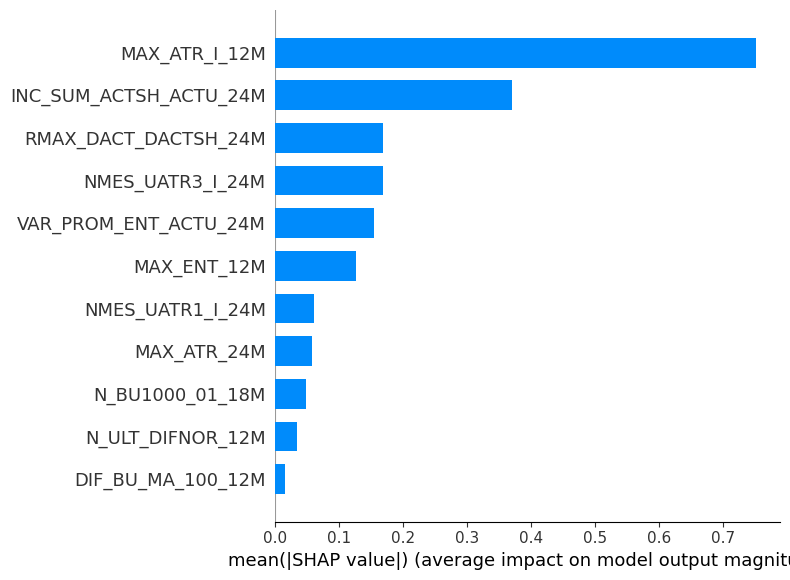

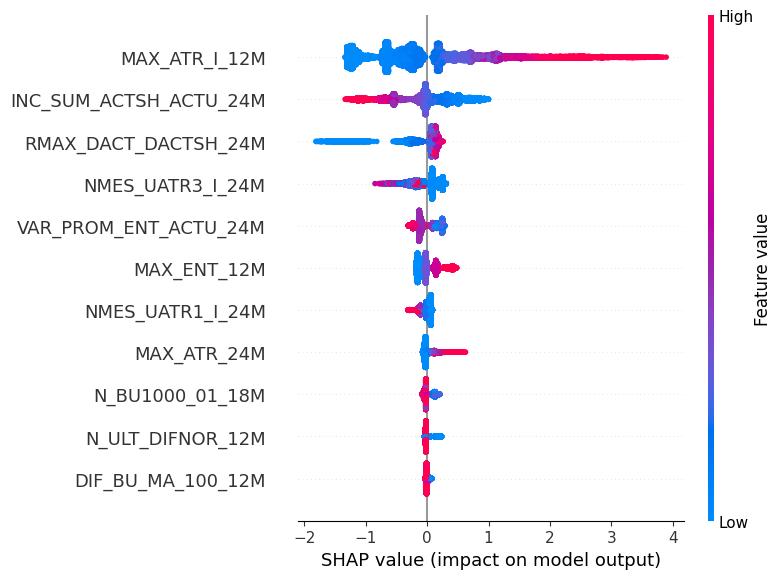

In [146]:
shap.summary_plot(shap_values, X_train[vars_finales_2], plot_type="bar", max_display=20)
shap.summary_plot(shap_values, X_train[vars_finales_2], max_display=20)

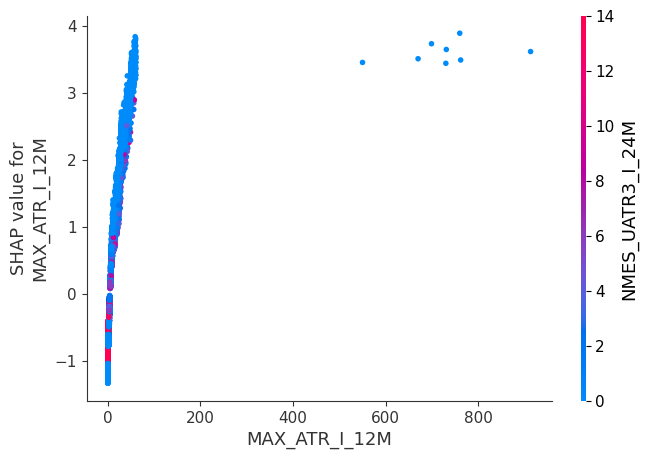

In [147]:
shap.dependence_plot('MAX_ATR_I_12M', shap_values, X_train[vars_finales_2])

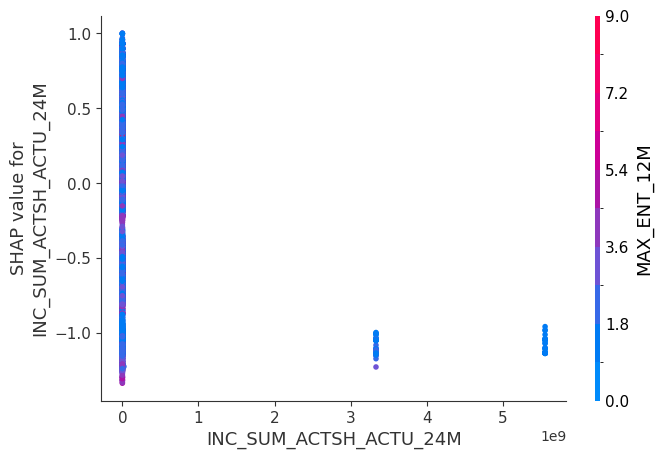

In [148]:
shap.dependence_plot('INC_SUM_ACTSH_ACTU_24M', shap_values, X_train[vars_finales_2])

In [149]:
df['muestra'] = np.where((df['PERIODO'] >= 201801),'OOT', 'TRAIN')
df['probab'] = best_hgb_retrain.predict_proba(df[vars_finales_2])[:, 1]
df['score_model'] = np.round((1-df['probab'])*1000)
df.to_csv('dataset_final.csv')
df

,PERIODO,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,...,VAR_MAX_CAL_ACTU_24M,VAR_PROM_DEUDIR_ACTU_12M,VAR_PROM_ENT_ACTU_24M,is_outlier,score,pca1,pca2,muestra,probab,score_model
0,201701,1,0,12.0,20.0,12.0,10.0,12.0,0.0,0.000000,...,0.0,-0.549849,0.000000,1,0.275856,-0.760017,-1.297138,TRAIN,0.343944,656.0
1,201701,2,0,10.0,19.0,10.0,7.0,10.0,0.0,7.638805,...,0.0,0.941415,0.000000,1,0.218606,-0.417749,-1.415934,TRAIN,0.275537,724.0
2,201701,3,0,8.0,8.0,8.0,7.0,8.0,0.0,0.000000,...,0.0,0.576363,0.000000,1,0.203407,-0.016588,-2.644335,TRAIN,0.047072,953.0
3,201701,4,0,12.0,24.0,12.0,12.0,12.0,0.0,0.149661,...,0.0,-0.164709,0.010417,1,0.216930,-0.331933,1.769424,TRAIN,0.264512,735.0
4,201701,5,0,12.0,24.0,12.0,12.0,12.0,0.0,0.771430,...,0.0,0.360133,0.055556,1,0.270545,-0.514838,0.770799,TRAIN,0.320825,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,201803,50616,1,8.0,20.0,8.0,8.0,8.0,1.0,0.540074,...,0.0,0.073579,-0.395833,1,0.087120,4.442208,-0.212594,OOT,0.945755,54.0
50616,201803,50617,1,5.0,5.0,5.0,5.0,5.0,0.0,0.383603,...,0.0,0.177697,0.000000,1,0.209484,0.433357,-2.777821,OOT,0.329096,671.0
50617,201803,50618,1,12.0,14.0,12.0,12.0,12.0,0.0,0.157551,...,0.0,-0.385030,-0.428571,1,0.227291,-0.322933,0.106140,OOT,0.704248,296.0
50618,201803,50619,1,5.0,9.0,5.0,5.0,5.0,0.0,0.067838,...,0.0,-0.278086,0.000000,1,0.201391,0.413852,-2.483187,OOT,0.424404,576.0


In [39]:
df = pd.read_csv('dataset_final.csv', index_col=0)
df

,PERIODO,ID,FLG_CLI_DEF60,DIF_BU_MA_100_12M,DIF_BU_MA_100_24M,DIF_BU_MA_12M,DIF_BU_MA_500_12M,DIF_BU_MA_ALI_12M,FLG_DVNCD_24M,INC_MAX_DTOTSH_ACTU_24M,...,VAR_MAX_CAL_ACTU_24M,VAR_PROM_DEUDIR_ACTU_12M,VAR_PROM_ENT_ACTU_24M,is_outlier,score,pca1,pca2,muestra,probab,score_model
0,201701,1,0,12.0,20.0,12.0,10.0,12.0,0.0,0.000000,...,0.0,-0.549849,0.000000,1,0.275856,-0.760017,-1.297138,TRAIN,0.343944,656.0
1,201701,2,0,10.0,19.0,10.0,7.0,10.0,0.0,7.638805,...,0.0,0.941415,0.000000,1,0.218606,-0.417749,-1.415934,TRAIN,0.275537,724.0
2,201701,3,0,8.0,8.0,8.0,7.0,8.0,0.0,0.000000,...,0.0,0.576363,0.000000,1,0.203407,-0.016588,-2.644335,TRAIN,0.047072,953.0
3,201701,4,0,12.0,24.0,12.0,12.0,12.0,0.0,0.149661,...,0.0,-0.164709,0.010417,1,0.216930,-0.331933,1.769424,TRAIN,0.264512,735.0
4,201701,5,0,12.0,24.0,12.0,12.0,12.0,0.0,0.771430,...,0.0,0.360133,0.055556,1,0.270545,-0.514838,0.770799,TRAIN,0.320825,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,201803,50616,1,8.0,20.0,8.0,8.0,8.0,1.0,0.540074,...,0.0,0.073579,-0.395833,1,0.087120,4.442208,-0.212594,OOT,0.945755,54.0
50616,201803,50617,1,5.0,5.0,5.0,5.0,5.0,0.0,0.383603,...,0.0,0.177697,0.000000,1,0.209484,0.433357,-2.777821,OOT,0.329096,671.0
50617,201803,50618,1,12.0,14.0,12.0,12.0,12.0,0.0,0.157551,...,0.0,-0.385030,-0.428571,1,0.227291,-0.322933,0.106140,OOT,0.704248,296.0
50618,201803,50619,1,5.0,9.0,5.0,5.0,5.0,0.0,0.067838,...,0.0,-0.278086,0.000000,1,0.201391,0.413852,-2.483187,OOT,0.424404,576.0


In [150]:
print('GINI OOT: ' ,gini_score(df[(df['muestra']=='OOT')&(df['is_outlier']==1)]['FLG_CLI_DEF60'], df[(df['muestra']=='OOT')&(df['is_outlier']==1)]['score_model']))

GINI OOT:  0.673423307887308


# 6) Resultados y Monitoreo

## 6.1 Calculo de Punto de Corte Optimo

Punto de Corte Óptimo ( 510.0 )
Sensibilidad: 0.7314148681055156
Especificidad: 0.7947090243015744


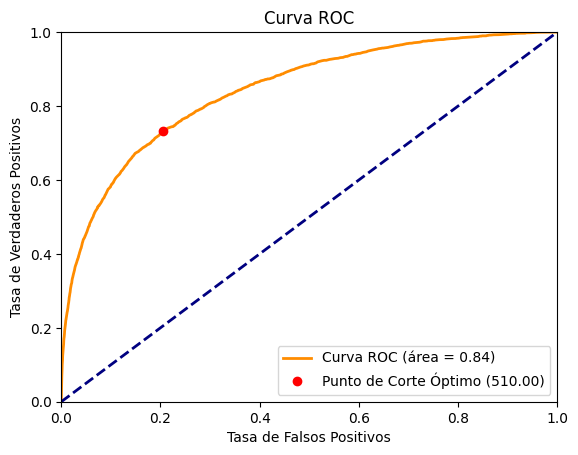

In [164]:
X_train_final = df[(df['muestra']=='TRAIN')&(df['is_outlier']==1)]
fpr, tpr, thresholds = roc_curve(X_train_final['FLG_CLI_DEF60'], X_train_final['score_model'], pos_label=1)
roc_auc = auc(fpr, tpr)
tpr_graf = (1-tpr)
fpr_graf = (1-fpr)
optimal_idx = np.argmax(tpr_graf - fpr_graf)
optimal_threshold = thresholds[optimal_idx]
print('Punto de Corte Óptimo (',optimal_threshold,')')
print('Sensibilidad:',tpr_graf[optimal_idx])
print('Especificidad:',1-fpr_graf[optimal_idx])

plt.figure()
#plt.plot(1-fpr, 1-tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot(1-fpr, 1-tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % (1-roc_auc))
plt.plot(fpr_graf[optimal_idx], tpr_graf[optimal_idx], 'ro', label=f'Punto de Corte Óptimo ({optimal_threshold:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right");

## 6.2 Calculo de Corte de Variables para medir Estabilidad

In [227]:
vars_continuas = vars_finales_2
vars_continuas.append('score_model')

In [228]:
# Cortes de Deciles para el SCORE
deciles = np.percentile(X_train_final['score_model'].dropna(), np.arange(0, 101, 10))
cortes_superiores = deciles[1:]
print(cortes_superiores)
cortes_superiores = [str(int(valor)) for valor in cortes_superiores]
cortes_superiores[len(cortes_superiores)-1] = 'mas de '+str(cortes_superiores[len(cortes_superiores)-2])
cortes_superiores

[253. 436. 548. 626. 687. 745. 799. 848. 898. 994.]


['253', '436', '548', '626', '687', '745', '799', '848', '898', 'mas de 898']

In [229]:
vars_personalizados = {
    #'woe_ratio_comparacion_u1m_u12m': ['0.0475', '0.25456', '0.54684', 'mas de 0.54684'], #editado
    'score_model' : cortes_superiores,
}

nombre_target = 'FLG_CLI_DEF60'

In [230]:
list_opt = list()eeeeeeee
y = X_train_final[nombre_target].to_numpy()
for var in vars_continuas:
    print(f'Variable: {var}')
    x_parcial = X_train_final[var].to_numpy()
    optb_temp = OptimalBinning(name = var, dtype="numerical", solver="cp", min_n_bins = 2, max_n_bins = 5, min_bin_size = 0.10, monotonic_trend = 'auto_asc_desc')
    optb_temp.fit(x_parcial, y)
    list_opt.append(optb_temp)
    del(x_parcial)
    del(optb_temp)

Variable: DIF_BU_MA_100_12M
Variable: INC_SUM_ACTSH_ACTU_24M
Variable: MAX_ATR_24M
Variable: MAX_ATR_I_12M
Variable: MAX_ENT_12M
Variable: NMES_UATR1_I_24M
Variable: NMES_UATR3_I_24M
Variable: N_BU1000_01_18M
Variable: N_ULT_DIFNOR_12M
Variable: RMAX_DACT_DACTSH_24M
Variable: VAR_PROM_ENT_ACTU_24M
Variable: score_model


In [231]:
def cortes_superiores(buckets): # obtenemos todos los cortes superiores
    cortes_superiores = list()
    for a in buckets:
        if a != 'Missing' and 'inf)' not in a and len(a)>0: # verificamos que no sea missing, ni sea el ultimo bucket ni vacio
            corte_superior = a.split(',')[-1].replace(" ", "")[:-1]
            cortes_superiores.append(corte_superior)
    ultimo_valor = cortes_superiores[len(cortes_superiores)-1]
    cortes_superiores.append(f'mas de {ultimo_valor}')
    return cortes_superiores

In [232]:
def quintiles(variable):
    array_valores = df[variable].to_numpy()
    array_valores_sin_nan = array_valores[~np.isnan(array_valores)]
    # Calcular los quintiles
    quintiles = np.nanpercentile(array_valores_sin_nan, [20, 40, 60, 80])
    print(quintiles)
    cortes_unicos = sorted(list(set(quintiles)))
    print(cortes_unicos)
    ultimo_valor = cortes_unicos[len(cortes_unicos)-1]
    cortes_unicos.append(f'mas de {ultimo_valor}')
    cortes_unicos = [str(a) for a in cortes_unicos]
    return cortes_unicos

In [233]:
def valores_discretos(variable):
    array_valores = sorted(list(df[variable].unique()))
    array_valores = sorted(map(int, array_valores))
    return array_valores

Variable: DIF_BU_MA_100_12M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.50)",4079,0.102156,3111,968,0.237313,-0.981419,0.142438,0.017123
1,"[6.50, 10.50)",8228,0.206066,7012,1216,0.147788,-0.39683,0.037904,0.004707
2,"[10.50, inf)",27622,0.691778,25636,1986,0.071899,0.408989,0.098424,0.012218
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.278766,0.034048


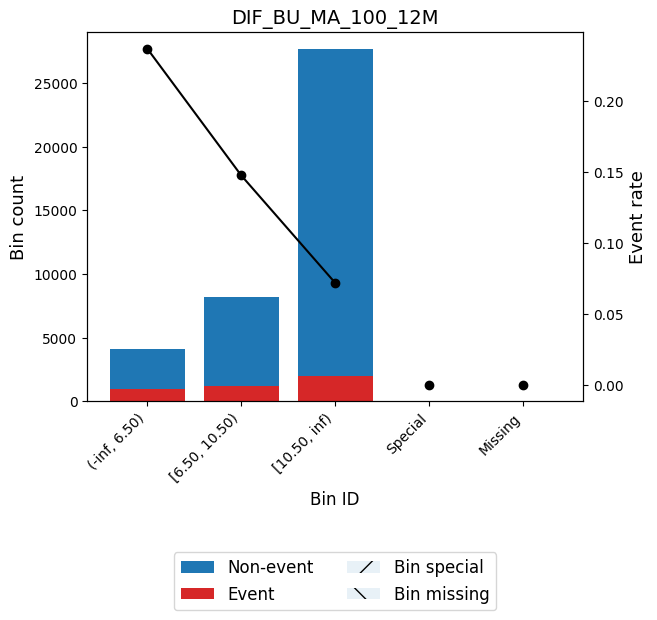

Cortes Optimos
['6.50', '10.50', 'mas de 10.50']


Variable: INC_SUM_ACTSH_ACTU_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.24)",6867,0.171980,5884,983,0.143148,-0.359503,0.025591,0.003182
1,"[8.24, 13.99)",9367,0.234591,8223,1144,0.122131,-0.176482,0.007833,0.000978
2,"[13.99, 20.46)",9328,0.233615,8381,947,0.101522,0.031537,0.000229,0.000029
3,"[20.46, 31.07)",7955,0.199229,7254,701,0.088121,0.187914,0.006530,0.000815
4,"[31.07, inf)",6412,0.160585,6017,395,0.061603,0.574572,0.042255,0.005210
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.082439,0.010214


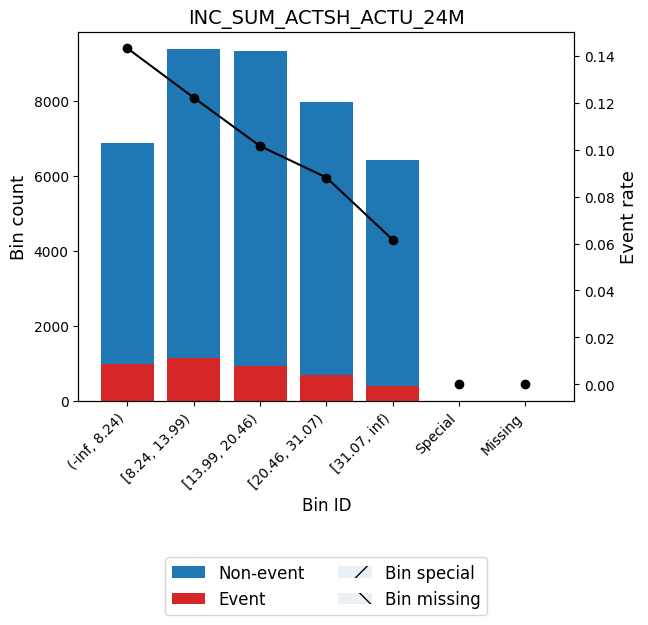

Cortes Optimos
['8.24', '13.99', '20.46', '31.07', 'mas de 31.07']


Variable: MAX_ATR_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",27254,0.682562,25410,1844,0.067660,0.47432,0.127300,0.015765
1,"[1.50, 10.50)",4505,0.112825,3928,577,0.128080,-0.230843,0.006584,0.000821
2,"[10.50, inf)",8170,0.204613,6421,1749,0.214076,-0.848356,0.203488,0.024700
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.337372,0.041286


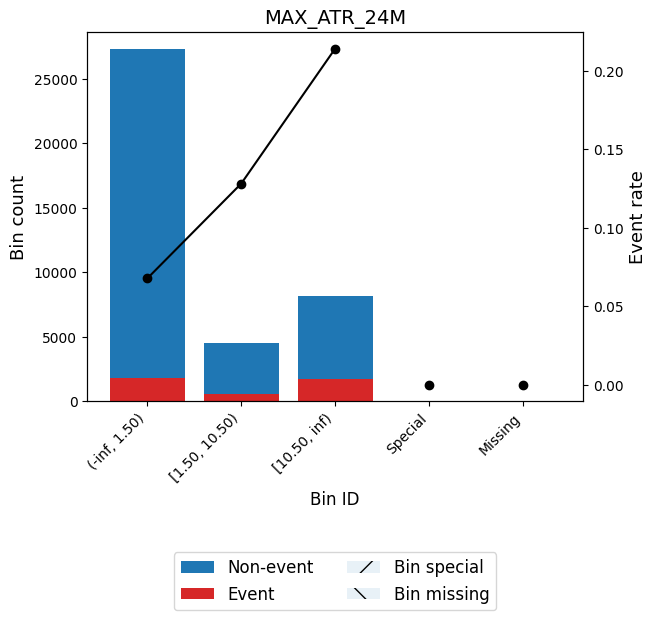

Cortes Optimos
['1.50', '10.50', 'mas de 10.50']


Variable: MAX_ATR_I_12M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6869,0.172030,6712,157,0.022856,1.60652,0.241060,0.027260
1,"[0.50, 1.50)",6188,0.154975,5957,231,0.037330,1.101019,0.122424,0.014574
2,"[1.50, 4.50)",10900,0.272985,10344,556,0.051009,0.774508,0.120774,0.014730
3,"[4.50, 10.50)",8943,0.223973,8065,878,0.098177,0.068756,0.001030,0.000129
4,"[10.50, inf)",7029,0.176037,4681,2348,0.334045,-1.458938,0.630503,0.072491
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,1.115791,0.129185


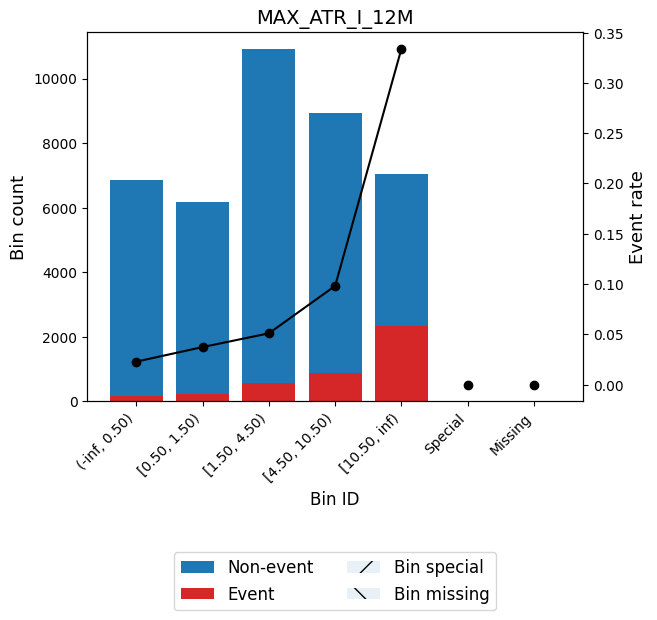

Cortes Optimos
['0.50', '1.50', '4.50', '10.50', 'mas de 10.50']


Variable: MAX_ENT_12M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",15815,0.396078,14623,1192,0.075371,0.358077,0.044072,0.005480
1,"[1.50, 2.50)",12467,0.312229,11147,1320,0.105880,-0.015347,0.000074,0.000009
2,"[2.50, 3.50)",7493,0.187658,6522,971,0.129588,-0.244276,0.012328,0.001537
3,"[3.50, inf)",4154,0.104035,3467,687,0.165383,-0.530175,0.035942,0.004441
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.092417,0.011467


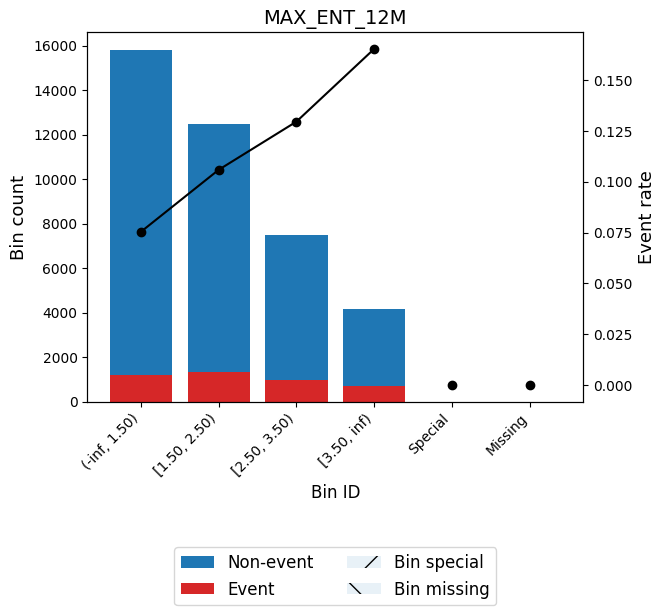

Cortes Optimos
['1.50', '2.50', '3.50', 'mas de 3.50']


Variable: NMES_UATR1_I_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",22893,0.573343,19527,3366,0.147032,-0.390813,0.102050,0.012676
1,"[0.50, 2.50)",8072,0.202159,7589,483,0.059836,0.605553,0.058375,0.007187
2,"[2.50, 5.50)",4361,0.109219,4171,190,0.043568,0.940001,0.066814,0.008057
3,"[5.50, inf)",4603,0.115280,4472,131,0.028460,1.381508,0.129371,0.014997
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.356609,0.042917


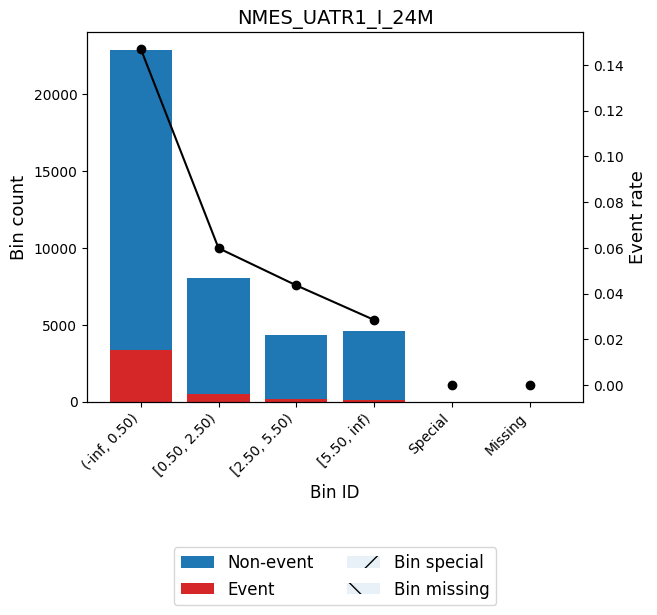

Cortes Optimos
['0.50', '2.50', '5.50', 'mas de 5.50']


Variable: NMES_UATR3_I_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",24232,0.606877,20984,3248,0.134038,-0.283165,0.054390,0.006776
1,"[0.50, 2.50)",5425,0.135866,4971,454,0.083687,0.244393,0.007366,0.000918
2,"[2.50, 7.50)",5513,0.138070,5220,293,0.053147,0.731194,0.055361,0.006770
3,"[7.50, inf)",4759,0.119187,4584,175,0.036772,1.116655,0.096284,0.011447
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.213401,0.025911


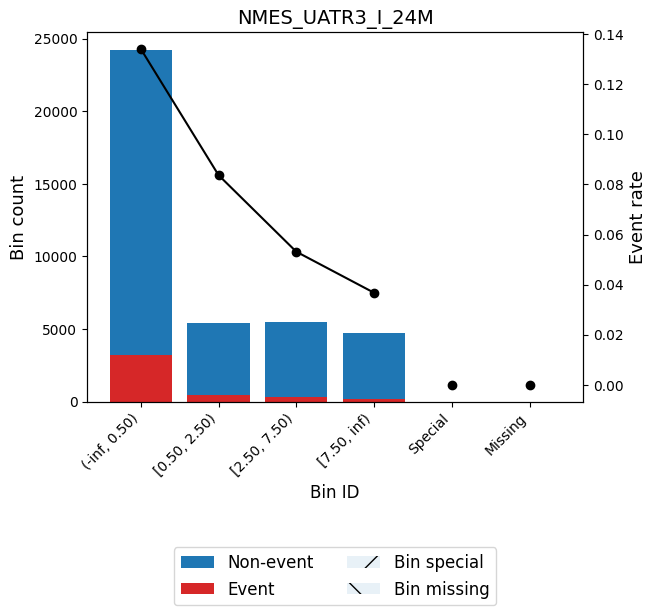

Cortes Optimos
['0.50', '2.50', '7.50', 'mas de 7.50']


Variable: N_BU1000_01_18M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",6782,0.169851,5935,847,0.124889,-0.201964,0.007502,0.000936
1,"[7.50, 15.50)",11152,0.279296,9919,1233,0.110563,-0.063884,0.001169,0.000146
2,"[15.50, 17.50)",4927,0.123394,4393,534,0.108382,-0.041514,0.000216,0.000027
3,"[17.50, inf)",17068,0.427459,15512,1556,0.091165,0.15061,0.009135,0.001141
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.018022,0.002250


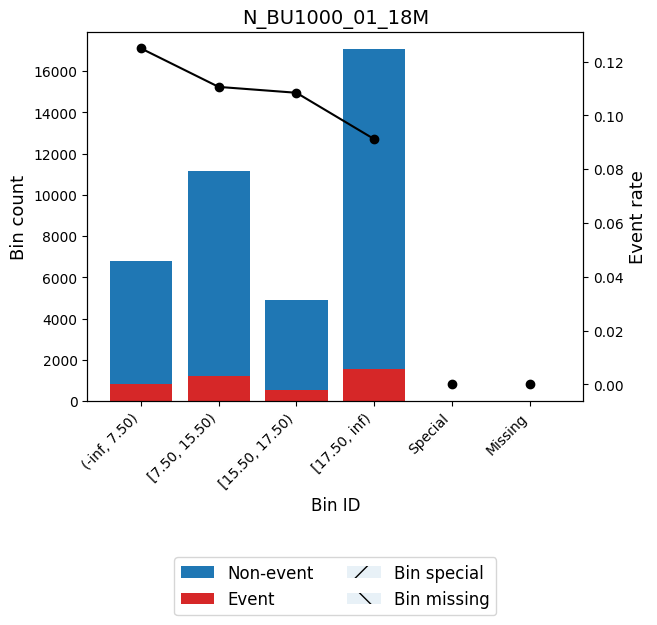

Cortes Optimos
['7.50', '15.50', '17.50', 'mas de 17.50']


Variable: N_ULT_DIFNOR_12M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.50)",5613,0.140575,4055,1558,0.277570,-1.192338,0.310274,0.036639
1,"[8.50, inf)",34316,0.859425,31704,2612,0.076116,0.347441,0.090412,0.011245
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.400686,0.047884


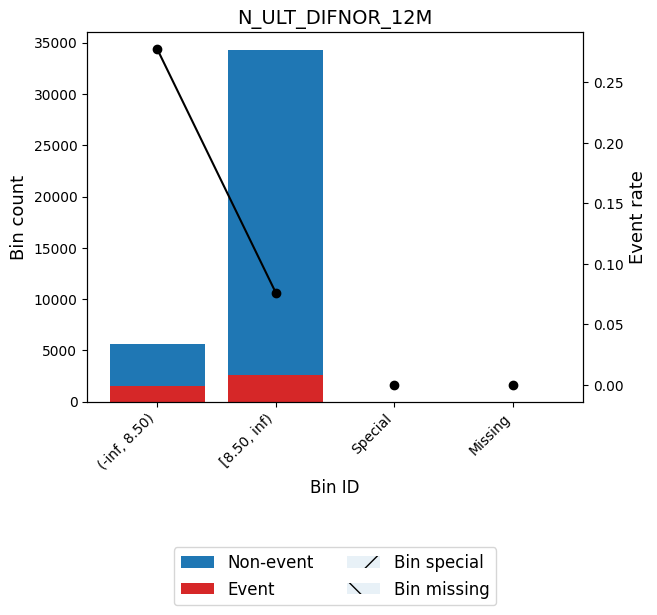

Cortes Optimos
['8.50', 'mas de 8.50']


Variable: RMAX_DACT_DACTSH_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.12)",6193,0.155100,5831,362,0.058453,0.630414,0.048071,0.005911
1,"[1.12, 1.37)",8318,0.208320,7517,801,0.096297,0.090176,0.001635,0.000204
2,"[1.37, 1.81)",13455,0.336973,11975,1480,0.109996,-0.058107,0.001164,0.000146
3,"[1.81, 2.03)",4348,0.108893,3805,543,0.124885,-0.201924,0.004808,0.000600
4,"[2.03, inf)",7615,0.190714,6631,984,0.129219,-0.241001,0.012179,0.001519
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.067857,0.008380


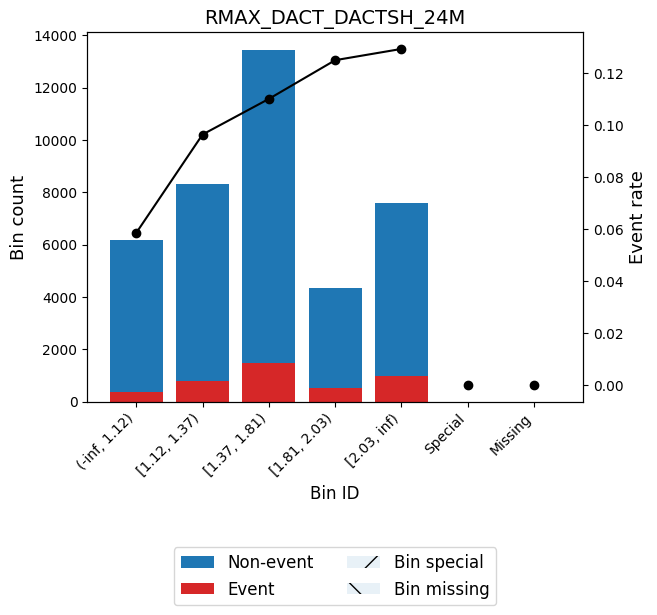

Cortes Optimos
['1.12', '1.37', '1.81', '2.03', 'mas de 2.03']


Variable: VAR_PROM_ENT_ACTU_24M


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -0.29)",6665,0.166921,5632,1033,0.154989,-0.452889,0.040861,0.005064
1,"[-0.29, -0.00)",10241,0.256480,8913,1328,0.129675,-0.245049,0.016961,0.002115
2,"[-0.00, 0.15)",18165,0.454933,16703,1462,0.080484,0.286897,0.033423,0.004164
3,"[0.15, inf)",4858,0.121666,4511,347,0.071429,0.416063,0.017864,0.002217
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,0.109109,0.013560


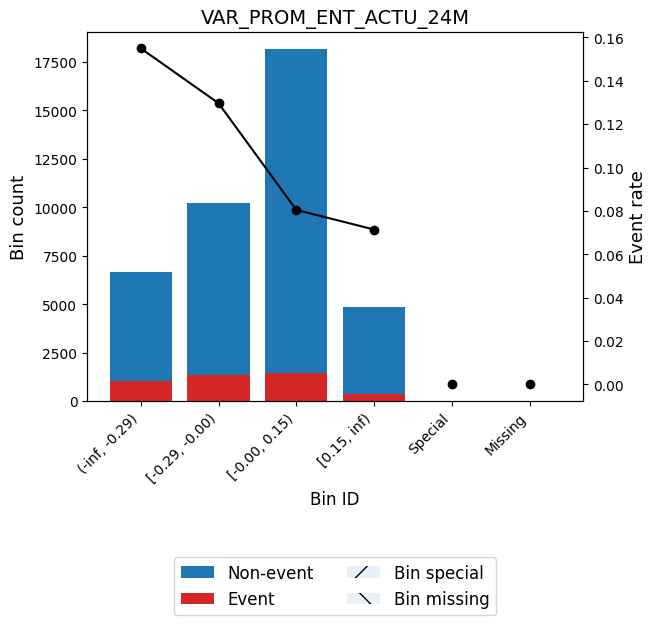

Cortes Optimos
['-0.29', '-0.00', '0.15', 'mas de 0.15']


Variable: score_model


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 348.50)",5779,0.144732,3380,2399,0.415124,-1.806062,0.868315,0.095840
1,"[348.50, 519.50)",4992,0.125022,4304,688,0.137821,-0.315375,0.014074,0.001752
2,"[519.50, 703.50)",10236,0.256355,9547,689,0.067311,0.479855,0.048827,0.006046
3,"[703.50, 826.50)",9158,0.229357,8866,292,0.031885,1.264339,0.224943,0.026383
4,"[826.50, inf)",9764,0.244534,9662,102,0.010447,2.402097,0.590285,0.059975
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39929,1.000000,35759,4170,0.104435,,1.746444,0.189995


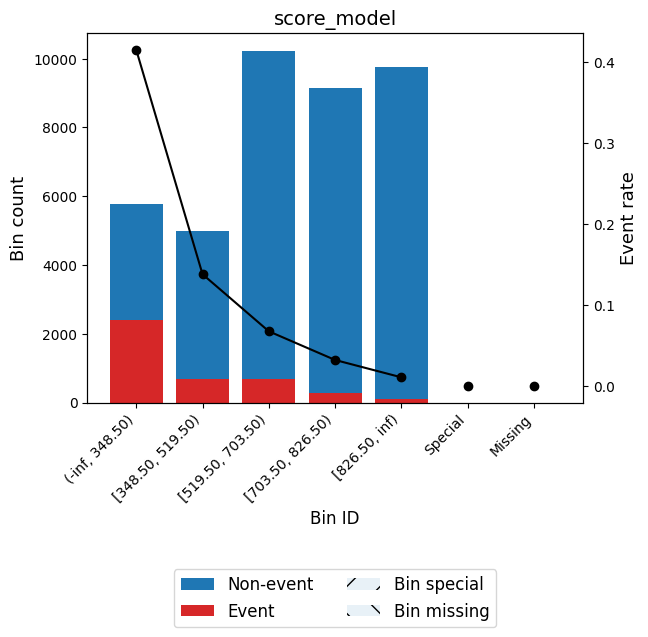

Cortes Optimos
['348.50', '519.50', '703.50', '826.50', 'mas de 826.50']




In [234]:
dict_variables_cortes_cont = dict()
for a in list_opt:
    binning_table = a.binning_table
    print(f'Variable: {a.name}'.center(20))
    build_table = binning_table.build()
    display(build_table)
    binning_table.plot(metric="event_rate", show_bin_labels=True)
    buckets = build_table[~build_table['Bin'].isin(['Special', 'Missing'])]['Bin'].to_list()
    buckets.remove('')
    if len(buckets)>=2: # verificamos si se hicieron por lo menos 2 cortes
        tipo_corte = 'Corte Optimo'
        print('Cortes Optimos')
        cortes = cortes_superiores(buckets)
    else:
        tipo_corte = 'Corte Quintiles'
        print('Cortes Quintiles')
        cortes = quintiles(a.name)
    print(cortes)
    print('\n')
    dict_variables_cortes_cont[a.name] = [cortes,tipo_corte]

In [235]:
dict_total = dict_variables_cortes_cont

In [236]:
def get_columna_bucket(var, cortes):
    print('proceso: ', var)
    df_temp = X_train_final[[var, nombre_target]].copy() # optenemos el dataframe solo con la variable , sera una copia
    if var in vars_continuas:
        dict_buckets = dict()
        if var in vars_personalizados.keys():
            cortes = vars_personalizados.get(var)
        cortes.insert(0,float('-inf'))
        cortes[len(cortes)-1] = float('+inf')
        cortes = [float(a) for a in cortes]
        buckets_etiqueta = [f'<{cortes[a]},{cortes[a+1]}]' for a in range(len(cortes)-1)]
        condiciones = [df_temp[var].between(left = cortes[a], right = cortes[a+1], inclusive = 'right') for a in range(len(cortes)-1)]
        cortes[len(cortes)-1] = 999999999
        #print(buckets_etiqueta, cortes)
        for a in range(len(cortes)-1):
            dict_buckets[buckets_etiqueta[a]] = [cortes[a+1],a+1]
            #print(a,len(cortes)-2)
            if a == (len(cortes)-2):
                dict_buckets['Missing'] = [-999999999, a+2]
        df_temp['variable'] = var
        df_temp['estadistico'] = np.select(condiciones, buckets_etiqueta, default='Missing')
        df_temp['valor'] = df_temp['estadistico'].map(lambda x: dict_buckets[x][0])
        df_temp['num_orden'] = df_temp['estadistico'].map(lambda x: dict_buckets[x][1])
    elif var in vars_discretas:
        dict_buckets = dict()
        condiciones = [df_temp[var]==a for a in range(len(cortes))]
        df_temp['estadistico'] = np.select(condiciones, cortes, default='Missing')
        for a in range(len(cortes)):
            dict_buckets[cortes[a]] = [cortes[a],a+1]
            if a == (len(cortes)-1):
                dict_buckets['Missing'] = [-999999999, a+2]
        df_temp['variable'] = var
        df_temp['valor'] = df_temp['estadistico'].map(lambda x: dict_buckets[int(x)][0])
        df_temp['num_orden'] = df_temp['estadistico'].map(lambda x: dict_buckets[int(x)][1])     
    return df_temp

In [237]:
df_ref = pd.DataFrame()
for k, v in dict_total.items():
    variable = k
    buckets = v[0].copy()
    tipo_corte = v[1]
    #print(f'variable: {k}, {buckets}, {tipo_corte}')
    if k in vars_continuas:
        #print(k)
        df_temp = get_columna_bucket(variable, buckets)
        df_temp.head(5)
        result_parcial = (
            df_temp
            .groupby(['num_orden', 'variable', 'estadistico', 'valor'])
            .agg(
                cantidad=('variable', 'size'),  # Contar el número de ocurrencias
                buenos=(nombre_target, lambda x: (x == 0).sum()),  # Contar donde nombre_target es 0
                malos=(nombre_target, lambda x: (x == 1).sum())   # Contar donde nombre_target es 1
            )
            .reset_index()
        )

        # Calcular el ratio dividiendo cada cantidad por la suma de la cantidad por 'variable'
        result_parcial['ratio'] = result_parcial['cantidad'] / result_parcial.groupby('variable')['cantidad'].transform('sum')

        df_ref = pd.concat([df_ref, result_parcial], axis = 0)

proceso:  DIF_BU_MA_100_12M
proceso:  INC_SUM_ACTSH_ACTU_24M
proceso:  MAX_ATR_24M
proceso:  MAX_ATR_I_12M
proceso:  MAX_ENT_12M
proceso:  NMES_UATR1_I_24M
proceso:  NMES_UATR3_I_24M
proceso:  N_BU1000_01_18M
proceso:  N_ULT_DIFNOR_12M
proceso:  RMAX_DACT_DACTSH_24M
proceso:  VAR_PROM_ENT_ACTU_24M
proceso:  score_model


In [288]:
df_ref['valor'] = df_ref['valor'].map('{:.2f}'.format)
df_ref.to_excel('reference.xlsx')
df_ref

,num_orden,variable,estadistico,valor,cantidad,buenos,malos,ratio
0,1,DIF_BU_MA_100_12M,"<-inf,6.5]",6.50,4079,3111,968,0.102156
1,2,DIF_BU_MA_100_12M,"<6.5,10.5]",10.50,8228,7012,1216,0.206066
2,3,DIF_BU_MA_100_12M,"<10.5,inf]",999999999.00,27622,25636,1986,0.691778
0,1,INC_SUM_ACTSH_ACTU_24M,"<-inf,8.24]",8.24,6872,5889,983,0.172105
1,2,INC_SUM_ACTSH_ACTU_24M,"<8.24,13.99]",13.99,9368,8224,1144,0.234616
2,3,INC_SUM_ACTSH_ACTU_24M,"<13.99,20.46]",20.46,9324,8377,947,0.233514
3,4,INC_SUM_ACTSH_ACTU_24M,"<20.46,31.07]",31.07,7954,7253,701,0.199204
4,5,INC_SUM_ACTSH_ACTU_24M,"<31.07,inf]",999999999.00,6411,6016,395,0.160560
0,1,MAX_ATR_24M,"<-inf,1.5]",1.50,27254,25410,1844,0.682562
1,2,MAX_ATR_24M,"<1.5,10.5]",10.50,4505,3928,577,0.112825


In [1]:
import shutil

shutil.make_archive("models", "zip", "models")

'/home/ec2-user/SageMaker/repositorios/ibk-bigdata-riesgos-dev/__otros__/mb/models.zip'

In [2]:
1

1